# Problem Statement

As someone aspiring to become a data scientist, I am working on a case study to address a critical challenge in the ride-sharing industry: recruiting and retaining drivers. Driver churn is a persistent issue, with many drivers leaving suddenly or switching to competitors based on changing rates.

In a growing organization, high churn rates can escalate into significant problems. While expanding hiring criteria to include individuals without vehicles can help bring in new drivers, it comes with high acquisition costs. Frequent driver turnover disrupts operations, impacts morale, and makes acquiring new drivers much more expensive than retaining the existing ones.

For this case study, I am working with monthly driver data from 2019 and 2020 to predict whether a driver is likely to leave the organization. The dataset includes key attributes such as:

- **Demographics**: Information like city, age, gender, etc.  
- **Tenure Information**: Joining date and last working date.  
- **Historical Performance Data**: Quarterly ratings, monthly business metrics, grades, and income.  

The objective is to analyze patterns, build a predictive model, and gain insights into how driver attrition can be reduced. This exercise not only enhances my technical skills but also provides valuable experience in solving real-world business problems.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

# Observations on Data

In [2]:
df = pd.read_csv('data.csv')
df=pd.read_csv('data.csv', usecols=lambda column: column != df.columns[0])
df

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,08/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,740280,3
19100,09/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,448370,3
19101,10/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,0,2
19102,11/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,200420,2


#### Column Profiling
1. **MMMM-YY**: Reporting Date (Monthly)
   - The month and year of reporting in the format MMMM-YY (e.g., Jan-22, Feb-22).
2. **Driver_ID**: Unique ID for drivers
   - A unique identifier assigned to each driver.
3. **Age**: Age of the driver
   - The age of the driver as a numeric value.
4. **Gender**: Gender of the driver
   - Male: 0, Female: 1
5. **City**: City Code of the driver
   - A code representing the city where the driver is located.
6. **Education_Level**: Education level of the driver
   - 0: 10th grade or below
   - 1: 12th grade
   - 2: Graduate
7. **Income**: Monthly average income of the driver
   - The average monthly income of the driver as a numeric value.
8. **Date Of Joining**: Joining date of the driver
   - The date when the driver joined the platform.
9. **LastWorkingDate**: Last date of working for the driver
   - The last date the driver worked or was active on the platform.
10. **Joining Designation**: Designation of the driver at the time of joining
    - The role or position assigned to the driver when they joined.
11. **Grade**: Grade of the driver at the time of reporting
    - The grade assigned to the driver during the reporting period.
12. **Total Business Value**: Total business value acquired by the driver in a month
    - Represents the total value of business conducted by the driver in a given month. 
    - A negative value indicates cancellations, refunds, or car EMI adjustments.
13. **Quarterly Rating**: Quarterly rating of the driver
    - A rating given to the driver on a scale of 1 to 5, where a higher value indicates better performance.

It looks like dates are not formatted correctly so it will be better to correct it.

In [3]:
df["MMM-YY"] = pd.to_datetime(df["MMM-YY"], format="%m/%d/%y")

In [4]:
df["Dateofjoining"] = pd.to_datetime(df["Dateofjoining"], format="%d/%m/%y", errors='coerce')

In [5]:
df["LastWorkingDate"] = pd.to_datetime(df["LastWorkingDate"], format="%d/%m/%y", errors='coerce')

In [6]:
df.head(3)

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-11-03,1,1,0,2


In [7]:
df.shape

(19104, 13)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [9]:
df.isnull().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [10]:
df.Age.isnull().sum()

np.int64(61)

In [11]:
df[df.Age.isnull()]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
72,2020-02-01,20,NaN,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
97,2019-10-01,22,NaN,0.0,C10,2,31224,2018-05-25,NaT,1,1,200000,3
110,2019-07-01,24,NaN,0.0,C24,2,76308,2018-05-25,NaT,1,2,203240,3
212,2019-11-01,40,NaN,0.0,C15,0,59182,2019-08-11,NaT,2,2,0,1
261,2019-05-01,49,NaN,0.0,C20,0,53039,2018-05-25,NaT,1,2,124190,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18395,2020-05-01,2690,NaN,0.0,C11,2,77662,2018-07-17,NaT,1,2,692600,4
18722,2020-08-01,2730,NaN,1.0,C16,2,69924,2019-08-07,NaT,2,2,161860,2
18780,2019-03-01,2738,NaN,0.0,C17,0,23068,2018-08-09,NaT,1,1,639780,3
18843,2019-01-01,2751,NaN,0.0,C17,2,53115,2015-05-11,NaT,1,1,506550,3


In [12]:
df[df.Driver_ID==20]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
68,2019-10-01,20,26.0,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
69,2019-11-01,20,26.0,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
70,2019-12-01,20,26.0,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
71,2020-01-01,20,26.0,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
72,2020-02-01,20,NaN,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
73,2020-03-01,20,26.0,1.0,C19,0,40342,2019-10-25,2020-01-03,3,3,0,1


As the Driver_ID is unique for all the driver and there are rows where certain columns are null for the same driver but in other columns data is there, so it is better to populate those columns using already existing values

In [13]:
df = df.groupby('Driver_ID').apply(lambda group: group.ffill().bfill())
df = df.reset_index(drop=True)
df

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-11-03,1,1,2381060,2
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-11-03,1,1,-665480,2
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-11-03,1,1,0,2
3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-06-11,NaT,2,2,0,1
4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-06-11,NaT,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2020-08-01,2788,30.0,0.0,C27,2,70254,2020-08-06,NaT,2,2,740280,3
19100,2020-09-01,2788,30.0,0.0,C27,2,70254,2020-08-06,NaT,2,2,448370,3
19101,2020-10-01,2788,30.0,0.0,C27,2,70254,2020-08-06,NaT,2,2,0,2
19102,2020-11-01,2788,30.0,0.0,C27,2,70254,2020-08-06,NaT,2,2,200420,2


Note for coding:
- Group by Driver_ID: This ensures that operations are performed within each group corresponding to the same Driver_ID.
- ffill and bfill:
    - ffill() propagates the last valid observation forward.
    - bfill() propagates the next valid observation backward. Combining these ensures all NaN values within the group are filled with valid values from the same group.
- Reset Index: If grouping alters the DataFrame structure, resetting the index ensures consistency.

In [14]:
df.isnull().sum()

MMM-YY                     0
Driver_ID                  0
Age                        0
Gender                     0
City                       0
Education_Level            0
Income                     0
Dateofjoining              0
LastWorkingDate         8745
Joining Designation        0
Grade                      0
Total Business Value       0
Quarterly Rating           0
dtype: int64

In the LastWorkingDate, there are nulls so we can assume that those drivers are still working.

Aggregating on the Driver_ID column can provide insights into drivers' consistent behaviors or patterns over time. Here's an example Python code snippet demonstrating how to use mean, sum, or nunique to aggregate key metrics

In [15]:
df = df.groupby('Driver_ID').agg({
    'Age': 'mean',                     
    'Gender': 'unique',                
    'City': 'unique',                  
    'Education_Level': 'unique',       
    'Income': 'mean',                  
    'Dateofjoining': 'min',            
    'LastWorkingDate': 'max',          
    'Joining Designation': 'unique',   
    'Grade': 'unique',                   
    'Total Business Value': 'sum',     
    'Quarterly Rating': 'mean'         
})
df = df.reset_index()
df

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.000000,[0.0],[C23],[2],57387.0,2018-12-24,2019-11-03,[1],[1],1715580,2.000000
1,2,31.000000,[0.0],[C7],[2],67016.0,2020-06-11,NaT,[2],[2],0,1.000000
2,4,43.000000,[0.0],[C13],[2],65603.0,2019-07-12,2020-04-27,[2],[2],350000,1.000000
3,5,29.000000,[0.0],[C9],[0],46368.0,2019-09-01,2019-07-03,[1],[1],120360,1.000000
4,6,31.000000,[1.0],[C11],[1],78728.0,2020-07-31,NaT,[3],[3],1265000,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,33.500000,[0.0],[C24],[0],82815.0,2015-10-15,NaT,[2],[3],21748820,2.625000
2377,2785,34.000000,[1.0],[C9],[0],12105.0,2020-08-28,2020-10-28,[1],[1],0,1.000000
2378,2786,44.888889,[0.0],[C19],[0],35370.0,2018-07-31,2019-09-22,[2],[2],2815090,1.666667
2379,2787,28.000000,[1.0],[C20],[2],69498.0,2018-07-21,2019-06-20,[1],[1],977830,1.500000


In [16]:
df.shape

(2381, 12)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2381 non-null   int64         
 1   Age                   2381 non-null   float64       
 2   Gender                2381 non-null   object        
 3   City                  2381 non-null   object        
 4   Education_Level       2381 non-null   object        
 5   Income                2381 non-null   float64       
 6   Dateofjoining         2381 non-null   datetime64[ns]
 7   LastWorkingDate       1616 non-null   datetime64[ns]
 8   Joining Designation   2381 non-null   object        
 9   Grade                 2381 non-null   object        
 10  Total Business Value  2381 non-null   int64         
 11  Quarterly Rating      2381 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 223.3+ K

In [18]:
df.isnull().sum()

Driver_ID                 0
Age                       0
Gender                    0
City                      0
Education_Level           0
Income                    0
Dateofjoining             0
LastWorkingDate         765
Joining Designation       0
Grade                     0
Total Business Value      0
Quarterly Rating          0
dtype: int64

As mentioned earlier, the null values in LastWorkingDate are still working or not churned drivers

In [19]:
df.describe(include=['object'])

,Gender,City,Education_Level,Joining Designation,Grade
count,2381,2381,2381,2381,2381
unique,2,29,3,5,49
top,[0.0],[C20],[2],[1],[2]
freq,1404,152,802,1026,844


In [20]:
df.describe()

,Driver_ID,Age,Income,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating
count,2381.000000,2381.000000,2381.000000,2381,1616,2.381000e+03,2381.000000
mean,1397.559009,33.369155,59232.460484,2019-01-27 12:58:58.009239808,2019-12-26 23:22:34.455445760,4.586742e+06,1.566304
min,1.000000,21.000000,10747.000000,2013-01-04 00:00:00,2018-12-31 00:00:00,-1.385530e+06,1.000000
25%,695.000000,29.000000,39104.000000,2018-06-26 00:00:00,2019-06-10 00:00:00,0.000000e+00,1.000000
50%,1400.000000,33.000000,55285.000000,2019-06-23 00:00:00,2019-12-20 12:00:00,8.176800e+05,1.000000
75%,2100.000000,37.000000,75835.000000,2020-04-14 00:00:00,2020-07-14 00:00:00,4.173650e+06,2.000000
max,2788.000000,58.000000,188418.000000,2020-12-28 00:00:00,2020-12-28 00:00:00,9.533106e+07,4.000000
std,806.161628,5.890611,28298.214012,NaN,NaN,9.127115e+06,0.719652


#### Analysis
- Age
    - Mean Age: 33.36 years
    - Min Age: 21 years
    - Max Age: 58 years
    - Standard Deviation: 5.59 years (indicating a moderately spread-out age range).
- Income
    - Mean Income: 59,324 (monthly average income).
    - Min Income: 10,747 (potentially part-time drivers or new joiners).
    - Max Income: 188,418 (likely top performers or drivers in high-demand areas).
    - Std Dev: 28,929 (indicates wide income variability among drivers).
- Total Business Value
    - Mean Value: 4,586,742 (likely inflated by outliers as the range spans from negative to very high values).
    - Min Value: -1,385,530 (indicates cancellations, refunds, or adjustments).
    - Max Value: 95,331,060 (indicating exceptional performance).
    - The negative values suggest the need to assess cancellation patterns or refunds more closely.
- Quarterly Rating
    - Mean Rating: 1.56 out of 5.
    - Min Rating: 1 (lowest performance).
    - Max Rating: 4 (no one received the highest score of 5, which may indicate strict rating criteria).
    - Ratings appear skewed towards lower scores.
- Grade
    - Unique Grades: 49 unique values.
    - Most Frequent Grade (Top): 2, with 844 occurrences. This suggests that a significant number of drivers are concentrated at this grade.
- Gender
    - Unique Values: 2 (0: Male, 1: Female).
    - Top Value: Male (1404 entries or 59% of the data).
- City
    - Unique Values: 29 city codes.
    - Top City: C20 (152 drivers or 6.4%).
- Education_Level
    - Unique Values: 3 (0: Below 10th grade, 1: 12th grade, 2: Graduate).
    - Top Education Level: Graduate (802 entries or 33.7%).
- Joining Designation
    - Unique Values: 5 roles.
    - Top Designation: Most common is 1 (1026 drivers).
#### Insights
- **Active vs. Inactive Drivers:** Around 32% of drivers (765/2381) are still active on the platform. The rest have a LastWorkingDate, suggesting they left or became inactive.
- **Income Variability:** There is significant income disparity among drivers. Understanding factors like location, hours worked, or business value could help optimize income distribution.
- **Performance (Quarterly Rating):** The average quarterly rating is low (1.56 out of 5). Investigating reasons for underperformance and implementing support/training programs could improve ratings.
- **Education Level:** Most drivers are graduates, which may suggest a higher likelihood of tech-savvy individuals or those adaptable to digital platforms.
- **City Concentration:** While 29 cities are represented, the top city (C20) accounts for only 6.4% of drivers, suggesting a fairly balanced geographical spread.
- **Cancellations and Refunds:** Negative values in Total Business Value highlight a need to monitor and reduce cancellations or refunds.

# Univariate Analysis

In [21]:
df.head()

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,[0.0],[C23],[2],57387.0,2018-12-24,2019-11-03,[1],[1],1715580,2.0
1,2,31.0,[0.0],[C7],[2],67016.0,2020-06-11,NaT,[2],[2],0,1.0
2,4,43.0,[0.0],[C13],[2],65603.0,2019-07-12,2020-04-27,[2],[2],350000,1.0
3,5,29.0,[0.0],[C9],[0],46368.0,2019-09-01,2019-07-03,[1],[1],120360,1.0
4,6,31.0,[1.0],[C11],[1],78728.0,2020-07-31,NaT,[3],[3],1265000,1.6


In [22]:
df.select_dtypes(include=['int64', 'float64']).columns.tolist()

['Driver_ID', 'Age', 'Income', 'Total Business Value', 'Quarterly Rating']

In [23]:
[col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Driver_ID']

['Age', 'Income', 'Total Business Value', 'Quarterly Rating']

In [24]:
df.select_dtypes(include=['object', 'category']).columns.tolist()

['Gender', 'City', 'Education_Level', 'Joining Designation', 'Grade']

Column name: Gender and it contains 
 Gender
[0.0]    1404
[1.0]     977
Name: count, dtype: int64


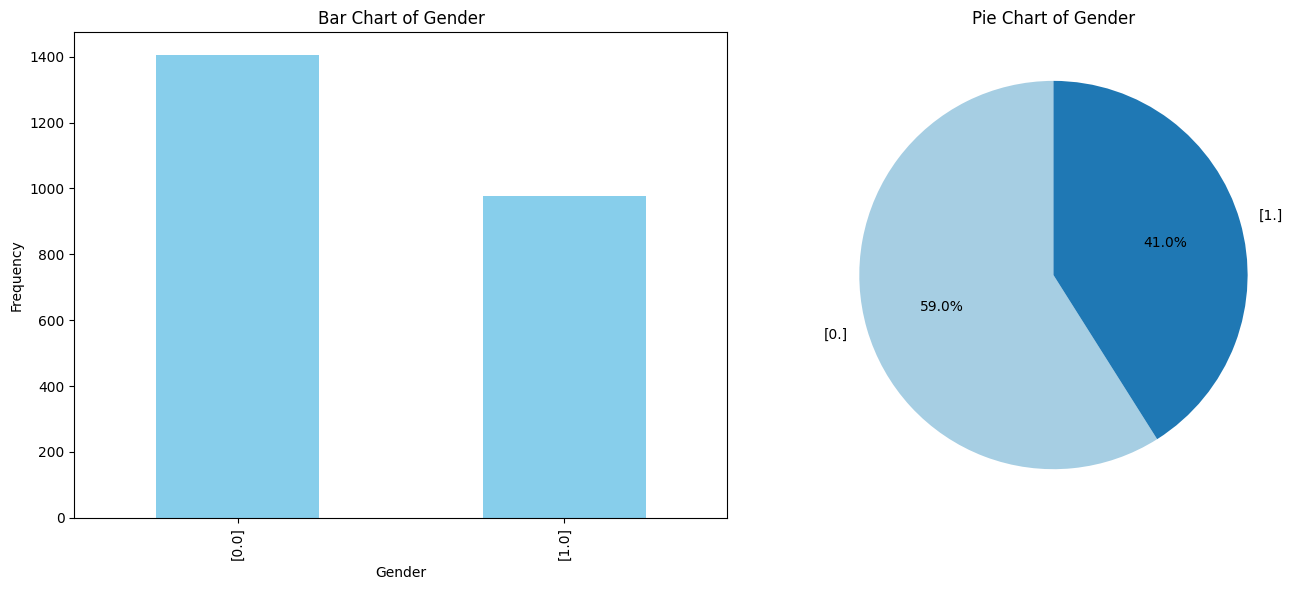

Column name: City and it contains 
 City
[C20]    152
[C15]    101
[C29]     96
[C26]     93
[C27]     89
[C8]      89
[C10]     86
[C16]     84
[C3]      82
[C22]     82
[C28]     82
[C12]     81
[C1]      80
[C5]      80
[C14]     79
[C21]     79
[C6]      78
[C4]      77
[C7]      76
[C9]      75
[C23]     74
[C25]     74
[C24]     73
[C19]     72
[C2]      72
[C13]     71
[C17]     71
[C18]     69
[C11]     64
Name: count, dtype: int64


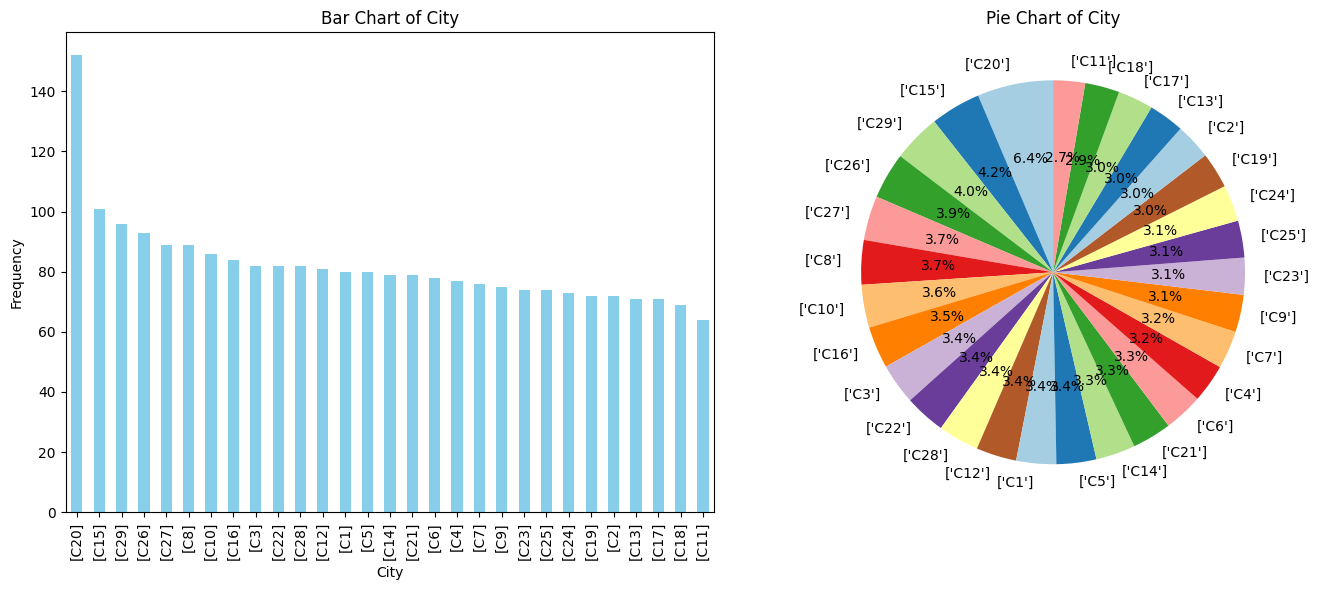

Column name: Education_Level and it contains 
 Education_Level
[2]    802
[1]    795
[0]    784
Name: count, dtype: int64


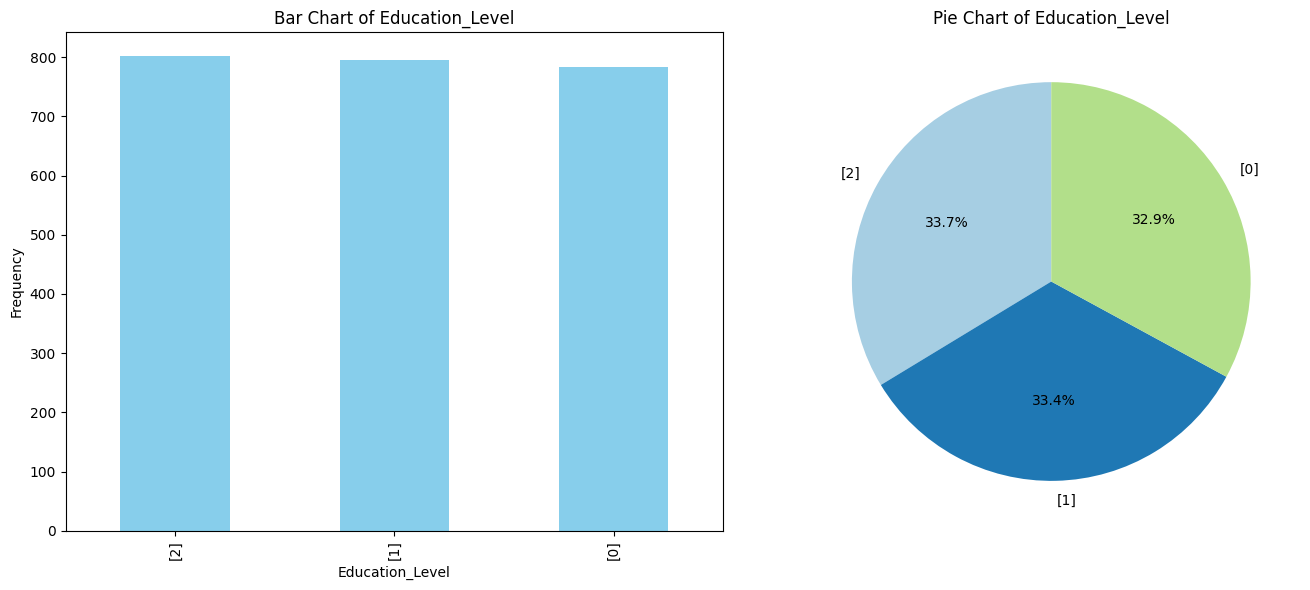

Column name: Joining Designation and it contains 
 Joining Designation
[1]    1026
[2]     815
[3]     493
[4]      36
[5]      11
Name: count, dtype: int64


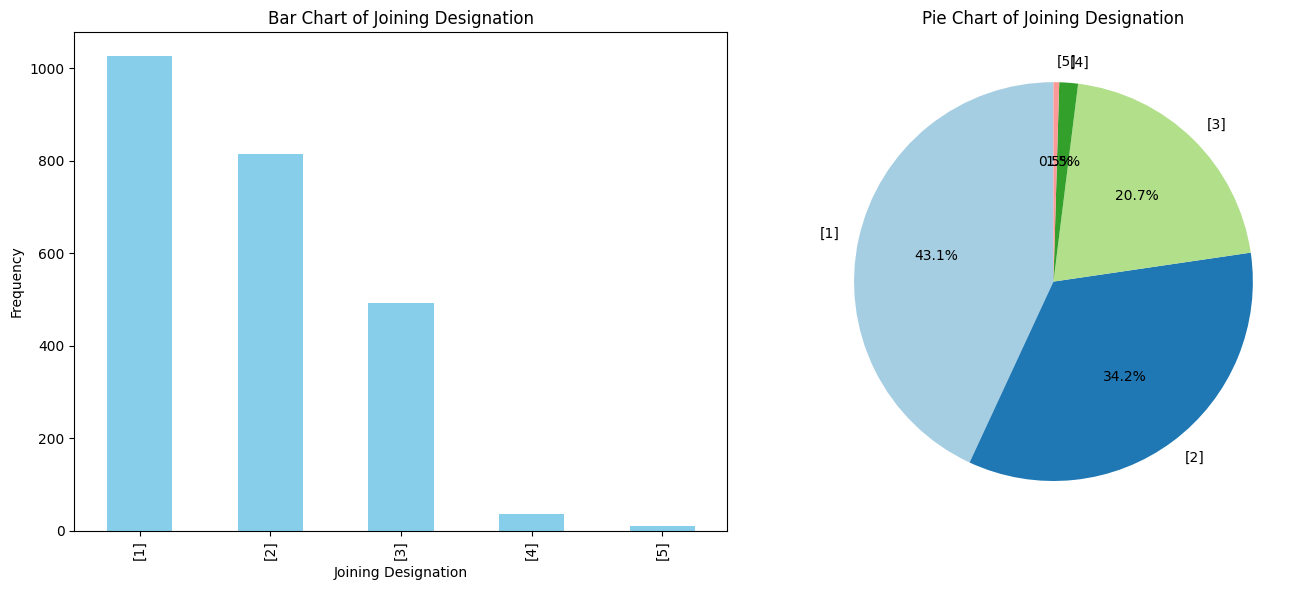

Column name: Grade and it contains 
 Grade
[2]       844
[1]       741
[3]       602
[4]       129
[5]        21
[3, 4]      1
[4, 5]      1
[3, 4]      1
[2, 3]      1
[3, 4]      1
[3, 4]      1
[1, 2]      1
[1, 2]      1
[2, 3]      1
[2, 3]      1
[3, 4]      1
[1, 2]      1
[2, 3]      1
[4, 5]      1
[2, 3]      1
[2, 3]      1
[1, 2]      1
[2, 3]      1
[1, 2]      1
[2, 3]      1
[2, 3]      1
[2, 3]      1
[1, 2]      1
[3, 4]      1
[2, 3]      1
[1, 2]      1
[3, 4]      1
[2, 3]      1
[2, 3]      1
[2, 3]      1
[2, 3]      1
[4, 5]      1
[2, 3]      1
[1, 2]      1
[3, 4]      1
[2, 3]      1
[2, 3]      1
[2, 3]      1
[1, 2]      1
[1, 2]      1
[2, 3]      1
[3, 4]      1
[2, 3]      1
[2, 3]      1
Name: count, dtype: int64


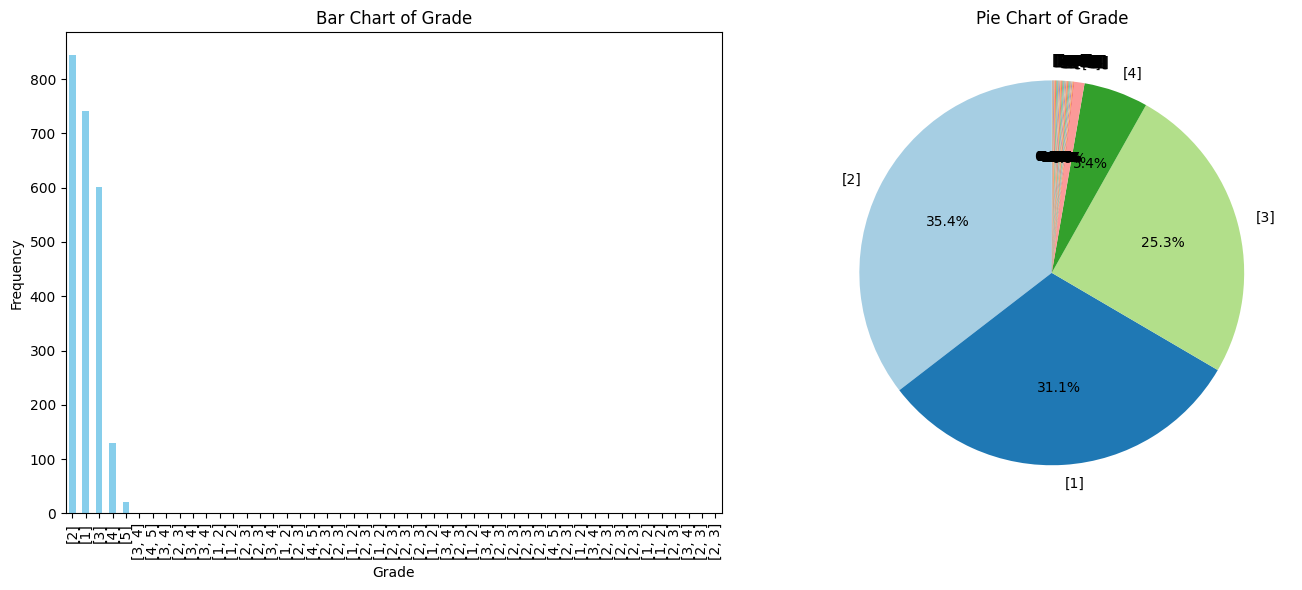

In [25]:
for i in df.select_dtypes(include=['object', 'category']).columns.tolist():
    print(f'Column name: {i} and it contains \n {df[i].value_counts()}')
    if len(df[i].value_counts()) > 50:
        print(f"\033[1mToo many values to plot bar and pie chart for column '{i}'\033[0m \n\n")
        continue
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    df[i].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Bar Chart of {i}')
    axes[0].set_xlabel(i)
    axes[0].set_ylabel('Frequency')
    pie_data = df[i].value_counts()
    axes[1].pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    axes[1].set_title(f'Pie Chart of {i}')
    plt.tight_layout()
    plt.show()

#### Analysis of Categorical Columns:
1. Gender
- Distribution:
    - **Male (0):** 59% (1404 drivers).
    - **Female (1):** 41% (977 drivers).
- Insights:
    - There is a noticeable gender gap, with males forming the majority of the workforce. This may indicate an opportunity to attract and empower more female drivers.
    - Gender diversity programs could be considered to balance the distribution.
2. City
- Top 3 Cities by Driver Count:
    - **C20:** 152 drivers (6.4%).
    - **C15:** 101 drivers (4.2%).
    - **C29:** 96 drivers (4.0%).
- Insights:
    - The driver distribution is relatively even across 29 cities, with no single city dominating.
    - High-performing cities (e.g., based on income or business value) should be further analyzed for best practices.
    - Smaller cities may represent growth opportunities for driver recruitment.
3. Education Level
- Distribution:
    - **Graduate (2):** 33.7% (802 drivers).
    - **12th Grade (1):** 33.4% (795 drivers).
    - **10th Grade or Below (0):** 32.9% (784 drivers).
- Insights:
    - The workforce is almost equally distributed across education levels.
    - A high percentage of graduates indicates that drivers may be adaptable to digital tools and technology.
    - For those with lower education levels, targeted training programs could help enhance performance.
4. Joining Designation
- Distribution:
    - **Designation 1:** 43.1% (1026 drivers).
    - **Designation 2:** 34.2% (815 drivers).
    - **Designation 3:** 20.7% (493 drivers).
    - **Designations 4 and 5:** Minimal representation (<2%).
- Insights:
    - Designation 1 is the most common joining role, which may represent an entry-level position.
    - Drivers in Designations 4 and 5 may represent specialized or senior roles. Understanding the progression from Designation 1 to higher levels can help design career growth paths.
5. Grade
- Distribution:
    - **Grade 2:** 35.4% (844 drivers).
    - **Grade 1:** 31.1% (741 drivers).
    - **Grade 3:** 25.3% (602 drivers).
    - **Grades 4 and 5:** Account for only **6.3% combined**.
    - The remaining grades are sparsely populated with individual entries.
- Insights:
    - The majority of drivers are clustered around Grades 1, 2, and 3, with fewer drivers achieving higher grades (4 or 5).
    - This distribution could indicate that reaching higher grades is challenging or reserved for exceptional performers.
    - Identifying factors contributing to higher grades (e.g., consistent income, fewer cancellations) could provide actionable insights to uplift more drivers to top grades.


--------------------------------------------------
Analysis for Column: Age
--------------------------------------------------
Skewness: 0.5304
Kurtosis: 0.1508

Top 10 value counts:
Age
32.0    121
31.0     99
34.0     89
30.0     88
33.0     86
29.0     84
36.0     78
35.0     75
28.0     73
27.0     67
Name: count, dtype: int64

Bottom 10 value counts:
Age
32.800000    1
27.545455    1
41.250000    1
32.636364    1
38.100000    1
31.307692    1
29.363636    1
45.842105    1
39.769231    1
33.266667    1
Name: count, dtype: int64

Z-scores (First 10 values):
[-0.91166832 -0.40227627  1.63529193 -0.74187097 -0.40227627  0.10711578
 -0.91166832  0.27691313 -0.63851606  0.95610253]

IQR value is 8.0
Upper Limit/Bound: 49.0
Lower Limit/Bound: 17.0
Number of rows which are outliners are 23



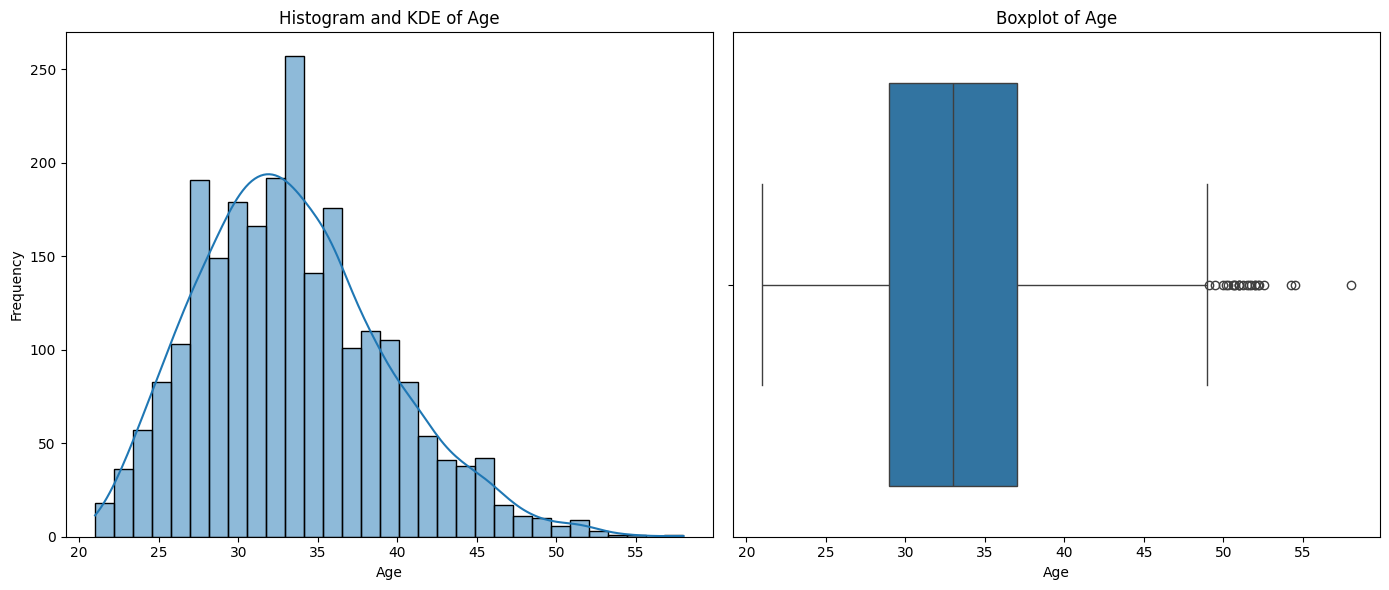


--------------------------------------------------
Analysis for Column: Income
--------------------------------------------------
Skewness: 0.7776
Kurtosis: 0.4564

Top 10 value counts:
Income
48747.0    3
41591.0    2
33721.0    2
49664.0    2
77903.0    2
64128.0    2
48097.0    2
83969.0    2
63181.0    2
12456.0    2
Name: count, dtype: int64

Bottom 10 value counts:
Income
19734.000000     1
52682.000000     1
51099.000000     1
31631.000000     1
40342.000000     1
22755.000000     1
31224.000000     1
76308.000000     1
102077.000000    1
126132.333333    1
Name: count, dtype: int64

Z-scores (First 10 values):
[-0.06522843  0.27511187  0.2251689  -0.45469876  0.68907652  0.40376891
 -0.60300782 -1.09982195  2.12052754 -1.39608661]

IQR value is 36731.0
Upper Limit/Bound: 130931.5
Lower Limit/Bound: -15992.5
Number of rows which are outliners are 47



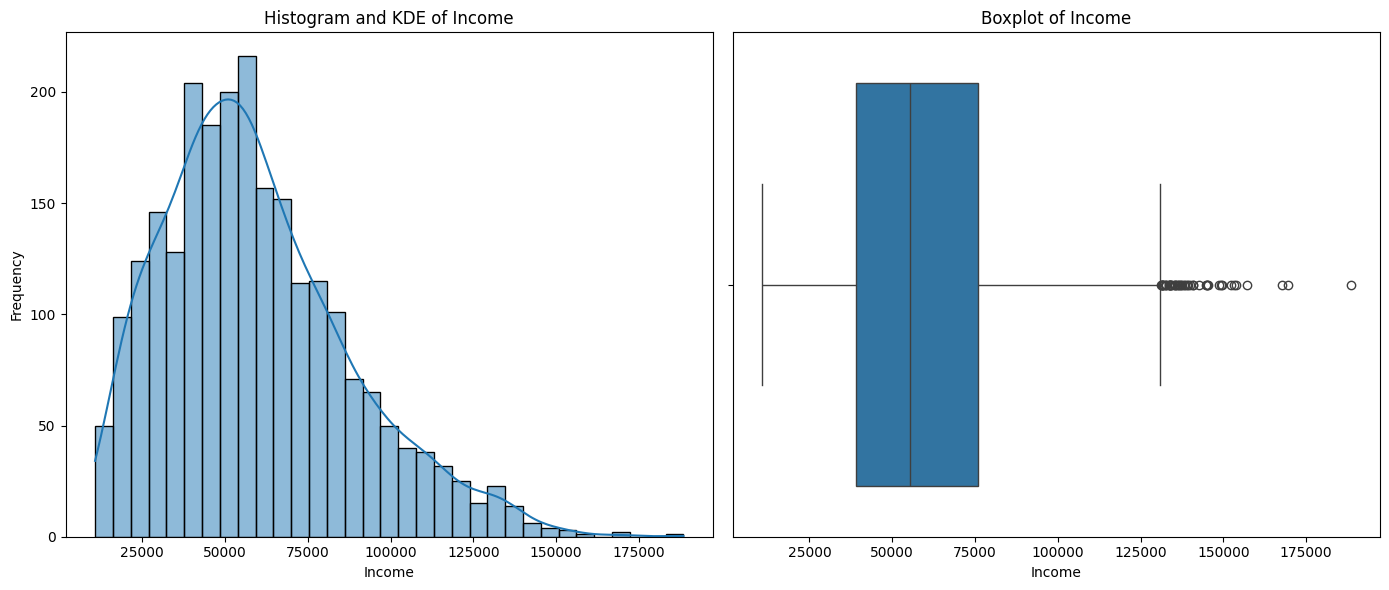


--------------------------------------------------
Analysis for Column: Total Business Value
--------------------------------------------------
Skewness: 3.3613
Kurtosis: 14.6539

Top 10 value counts:
Total Business Value
0         719
200000     10
250000      6
350000      5
600000      4
400000      3
500000      3
300000      3
116400      2
101850      2
Name: count, dtype: int64

Bottom 10 value counts:
Total Business Value
5945900     1
20843460    1
1834440     1
116940      1
3140390     1
1038200     1
61583040    1
5735920     1
1354530     1
69867900    1
Name: count, dtype: int64

Z-scores (First 10 values):
[-0.31464103 -0.50264571 -0.46429038 -0.48945586 -0.36401858 -0.50264571
 -0.50264571 -0.21693356  0.61656721 -0.50264571]

IQR value is 4173650.0
Upper Limit/Bound: 10434125.0
Lower Limit/Bound: -6260475.0
Number of rows which are outliners are 336



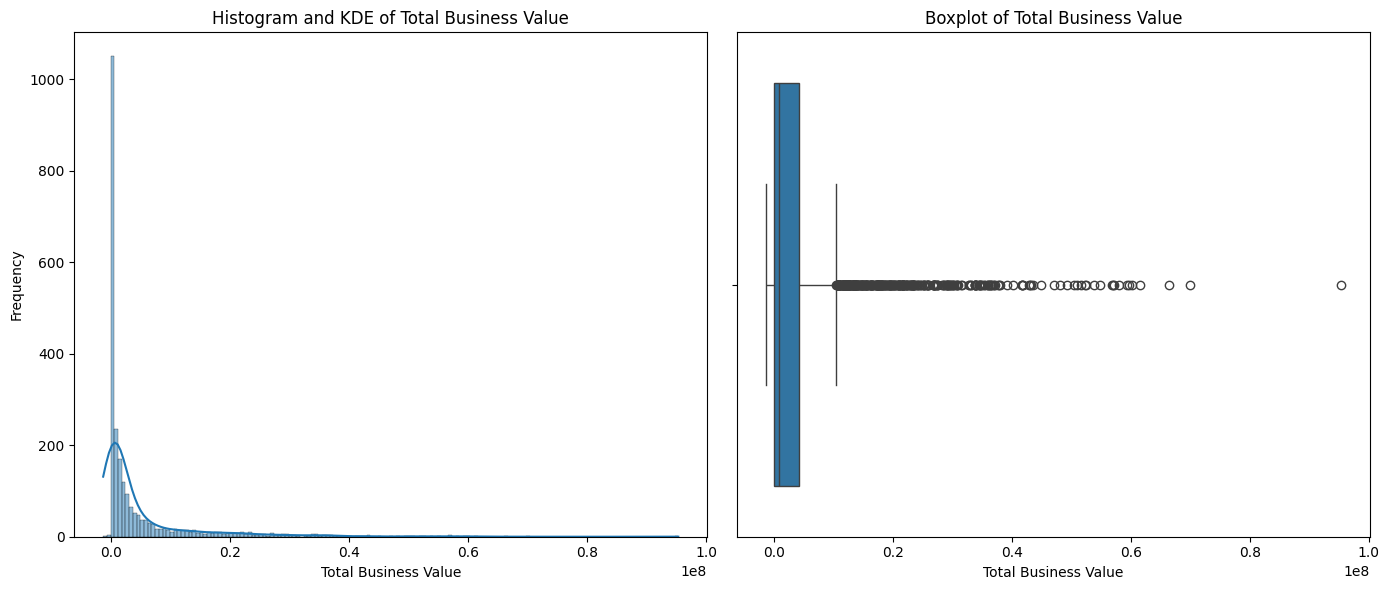


--------------------------------------------------
Analysis for Column: Quarterly Rating
--------------------------------------------------
Skewness: 1.0953
Kurtosis: 0.1937

Top 10 value counts:
Quarterly Rating
1.000000    1202
2.000000     116
1.600000      88
1.750000      72
2.500000      69
1.500000      59
3.000000      40
1.428571      39
2.750000      34
1.666667      32
Name: count, dtype: int64

Bottom 10 value counts:
Quarterly Rating
2.304348    1
1.727273    1
1.142857    1
1.705882    1
1.700000    1
2.550000    1
1.631579    1
2.565217    1
1.933333    1
1.882353    1
Name: count, dtype: int64

Z-scores (First 10 values):
[ 0.60277326 -0.78707919 -0.78707919 -0.78707919  0.04683228 -0.78707919
 -0.78707919  1.29769948 -0.42450898 -0.78707919]

IQR value is 1.0
Upper Limit/Bound: 3.5
Lower Limit/Bound: -0.5
Number of rows which are outliners are 28



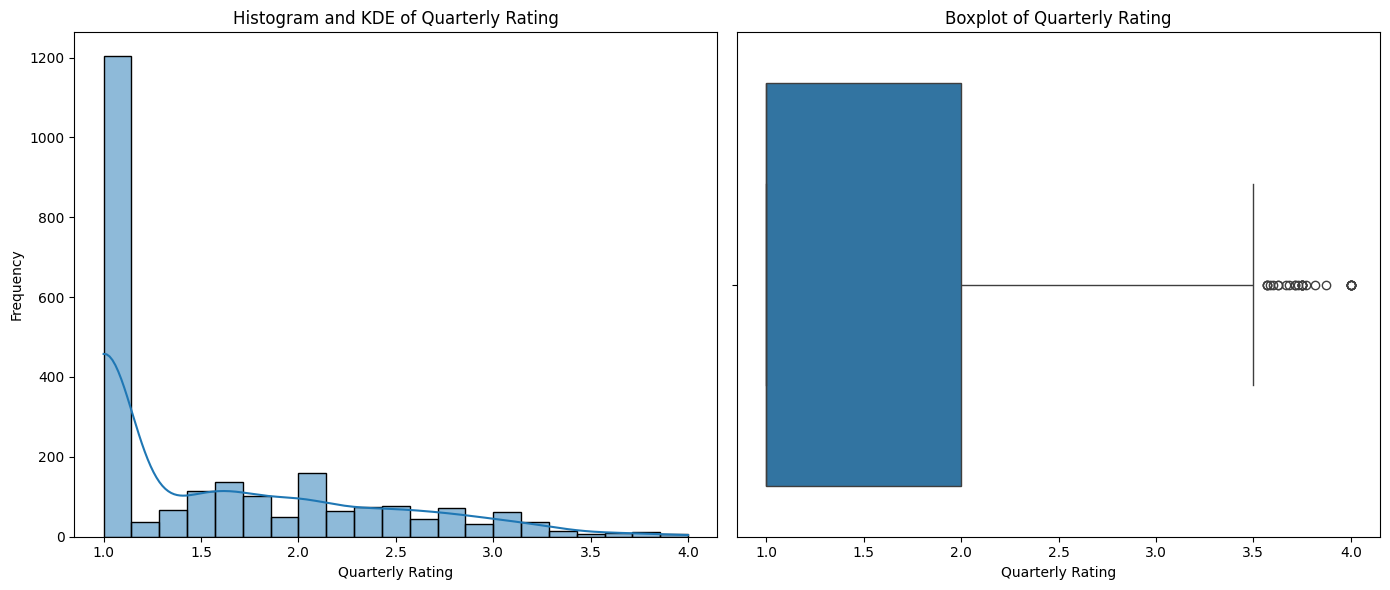

In [26]:
for i in [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Driver_ID']:
    print(f"\n{'-'*50}")
    print(f"Analysis for Column: {i}")
    print(f"{'-'*50}")
    skew_value = df[i].skew()
    print(f"Skewness: {skew_value:.4f}")
    kurt_value = df[i].kurt()
    print(f"Kurtosis: {kurt_value:.4f}")
    print("\nTop 10 value counts:")
    print(df[i].value_counts().head(10))
    print("\nBottom 10 value counts:")
    print(df[i].value_counts().tail(10))
    z_scores = zscore(df[i].dropna())
    print(f"\nZ-scores (First 10 values):")
    print(z_scores[:10])
    IQR = df[i].quantile(0.75)-df[i].quantile(0.25)
    print(f"\nIQR value is {IQR}\nUpper Limit/Bound: {df[i].quantile(0.75)+1.5*IQR}\nLower Limit/Bound: {df[i].quantile(0.25)-1.5*IQR}\nNumber of rows which are outliners are {df[(df[i]<df[i].quantile(0.25)-1.5*IQR) | (df[i]>df[i].quantile(0.75)+1.5*IQR)].shape[0]}\n")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.histplot(df[i], kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram and KDE of {i}')
    axes[0].set_xlabel(i)
    axes[0].set_ylabel('Frequency')
    sns.boxplot(x=df[i], ax=axes[1])
    axes[1].set_title(f'Boxplot of {i}')
    axes[1].set_xlabel(i)
    plt.tight_layout()
    plt.show()

#### Analysis of Numerical Columns:
1. Age
   - Skewness: 0.5304 (slightly positively skewed).
   - Kurtosis: 0.1508 (close to normal distribution).
   - Top Age Value: 32 (121 occurrences).
   - Bottom Age Value: Rare values (e.g., 32.800, 27.545 with 1 occurrence each).
   - Z-scores indicate no extreme outliers within the bounds of 17 and 49 years.
   - Number of Outliers: 23 (based on IQR analysis).
   - Visual Insights:
     - The histogram and KDE show a distribution centered around ages 30–35.
     - The boxplot indicates a small number of outliers above the upper bound.
2. Income
   - Skewness: 0.7776 (moderately positively skewed).
   - Kurtosis: 0.4564 (slightly leptokurtic).
   - Top Income Value: 48740 (3 occurrences).
   - Bottom Income Values: Low income like 19734 (1 occurrence).
   - Z-scores suggest some outliers in high-income ranges.
   - IQR: 36731.0.
   - Outliers: 47 rows above the upper bound (108931.5).
   - Visual Insights:
     - The histogram indicates a majority of drivers earn between 40000 and 80000.
     - Boxplot confirms the presence of a few high-income outliers.
3. Total Business Value
   - Skewness: 3.3613 (highly positively skewed).
   - Kurtosis: 14.6539 (highly leptokurtic, suggesting heavy tails).
   - Top Value: 0 (719 occurrences; cancellations/refunds).
   - High positive values: e.g., 500000, 300000.
   - Negative Values: e.g., -6206475 (outlier region).
   - Outliers: 336 rows with values outside IQR bounds.
   - Visual Insights:
     - The histogram is right-skewed with a peak at zero.
     - Boxplot highlights significant high-value outliers.
4. Quarterly Rating
   - Skewness: 1.8953 (strongly positively skewed).
   - Kurtosis: 0.1937 (close to normal distribution).
   - Top Value: 1.0 (1202 occurrences; lowest performance rating).
   - Bottom Value: Rare ratings like 2.304 (1 occurrence).
   - Z-scores show a tight spread around low ratings.
   - IQR: 1.0, suggesting tight distribution.
   - Outliers: 28 rows with high ratings (>3.5).
   - Visual Insights:
     - The histogram highlights a concentration around low ratings (1.0 to 2.0).
     - Boxplot confirms a small number of higher-rating outliers.

# Bivariate Analysis

In [27]:
df.head(10)

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.000000,[0.0],[C23],[2],57387.0,2018-12-24,2019-11-03,[1],[1],1715580,2.00000
1,2,31.000000,[0.0],[C7],[2],67016.0,2020-06-11,NaT,[2],[2],0,1.00000
2,4,43.000000,[0.0],[C13],[2],65603.0,2019-07-12,2020-04-27,[2],[2],350000,1.00000
3,5,29.000000,[0.0],[C9],[0],46368.0,2019-09-01,2019-07-03,[1],[1],120360,1.00000
4,6,31.000000,[1.0],[C11],[1],78728.0,2020-07-31,NaT,[3],[3],1265000,1.60000
5,8,34.000000,[0.0],[C2],[0],70656.0,2020-09-19,2020-11-15,[3],[3],0,1.00000
6,11,28.000000,[1.0],[C19],[2],42172.0,2020-07-12,NaT,[1],[1],0,1.00000
7,12,35.000000,[0.0],[C23],[2],28116.0,2019-06-29,2019-12-21,[1],[1],2607180,2.50000
8,13,29.608696,[0.0],[C19],[2],119227.0,2015-05-28,2020-11-25,[1],[4],10213040,1.26087
9,14,39.000000,[1.0],[C26],[0],19734.0,2020-10-16,NaT,[3],[3],0,1.00000


In [28]:
def plot_scatterplots(df, numerical_columns):
    for i, col1 in enumerate(numerical_columns):
        for col2 in numerical_columns[i+1:]:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df, x=col1, y=col2)
            plt.title(f"Scatter Plot: {col1} vs {col2}")
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.grid(True)
            plt.show()

In [34]:
def plot_boxplots(df, categorical_columns, numerical_columns):
    categorical_columns = [str(col) for col in categorical_columns]
    numerical_columns = [str(col) for col in numerical_columns]
    for cat_col in categorical_columns:
        for num_col in numerical_columns:
            try:
                plt.figure(figsize=(8, 6))
                sns.boxplot(data=df, x=cat_col, y=num_col)
                plt.title(f"Box Plot: {num_col} by {cat_col}")
                plt.xlabel(cat_col)
                plt.ylabel(num_col)
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.show()
            except Exception as e:
                print(f"Error plotting Box Plot for {cat_col} vs {num_col}: {e}")

In [30]:
def plot_stacked_bars_and_heatmaps(df, categorical_columns):
    for i, cat_col1 in enumerate(categorical_columns):
        for cat_col2 in categorical_columns[i+1:]:
            crosstab = pd.crosstab(df[cat_col1].astype(str), df[cat_col2].astype(str))
            crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
            fig, axes = plt.subplots(1, 2, figsize=(20, 10))
            crosstab.plot(kind='bar', stacked=True, ax=axes[0])
            axes[0].set_title(f"Stacked Bar Plot: {cat_col1} vs {cat_col2}")
            axes[0].set_xlabel(cat_col1)
            axes[0].set_ylabel("Frequency")
            axes[0].tick_params(axis='x', rotation=45)
            axes[0].grid(True)
            axes[0].legend(title=cat_col2, bbox_to_anchor=(1.05, 1), loc='upper left')
            sns.heatmap(crosstab_percentage, annot=True, fmt='.1f', cmap='Blues', ax=axes[1], cbar_kws={'format': '%.0f%%'})
            axes[1].set_title(f"Heatmap (Percentage): {cat_col1} vs {cat_col2}")
            axes[1].set_xlabel(cat_col2)
            axes[1].set_ylabel(cat_col1)
            plt.tight_layout()
            plt.show()

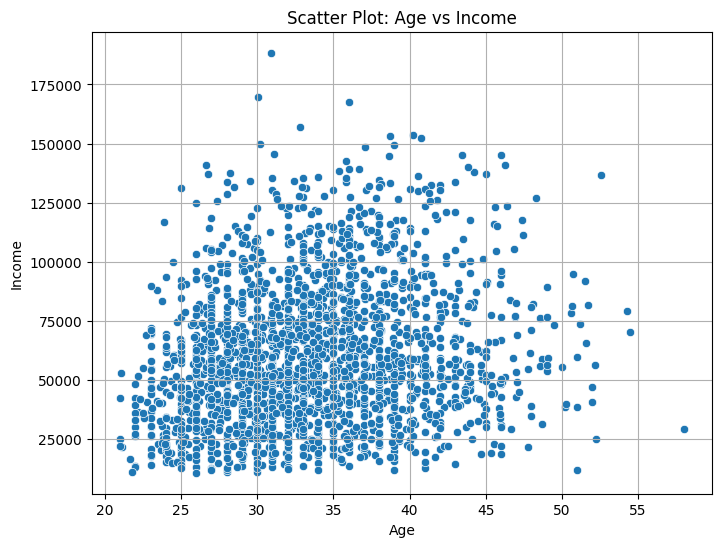

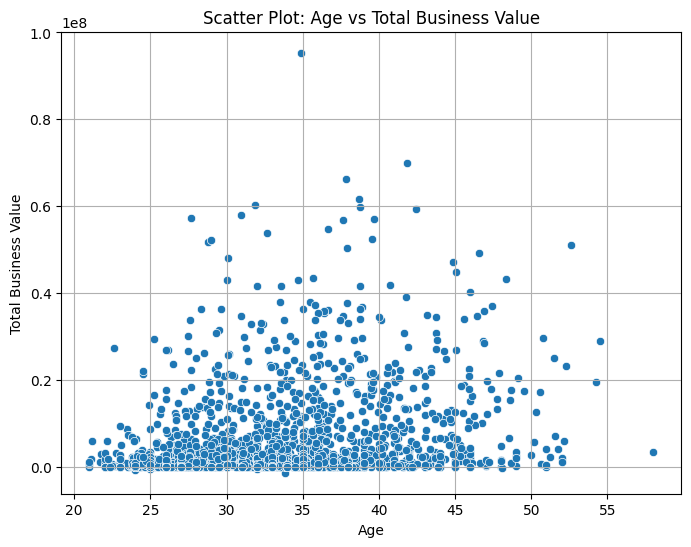

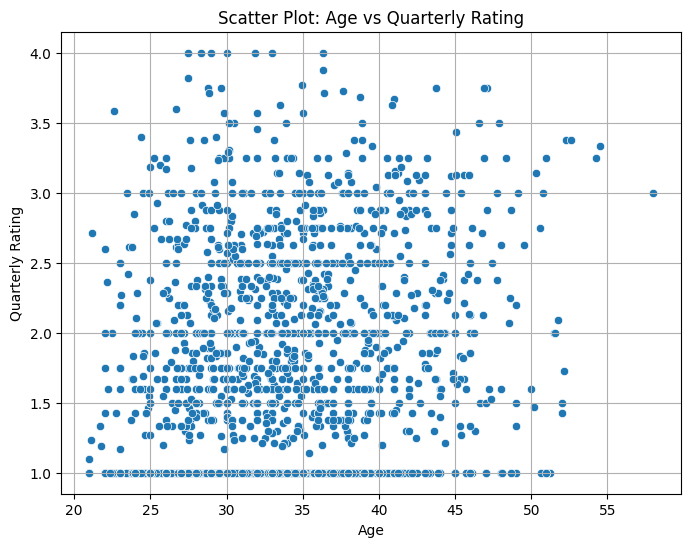

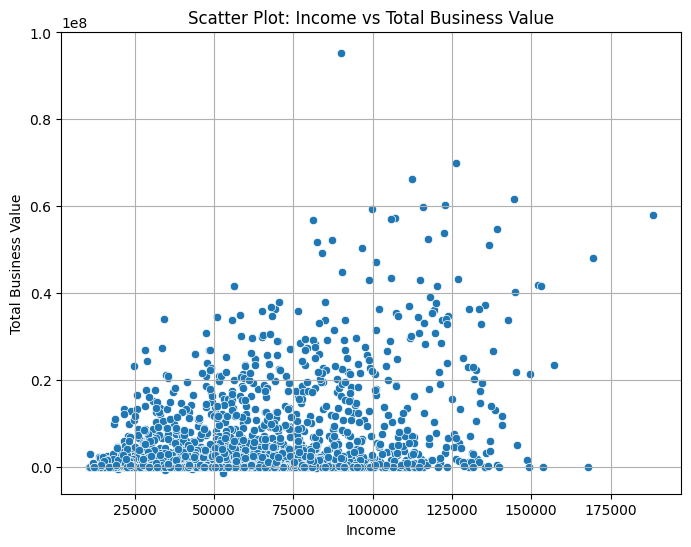

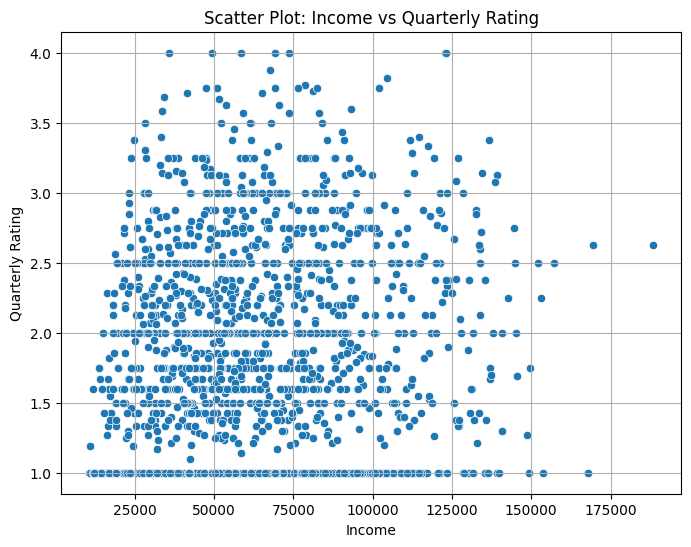

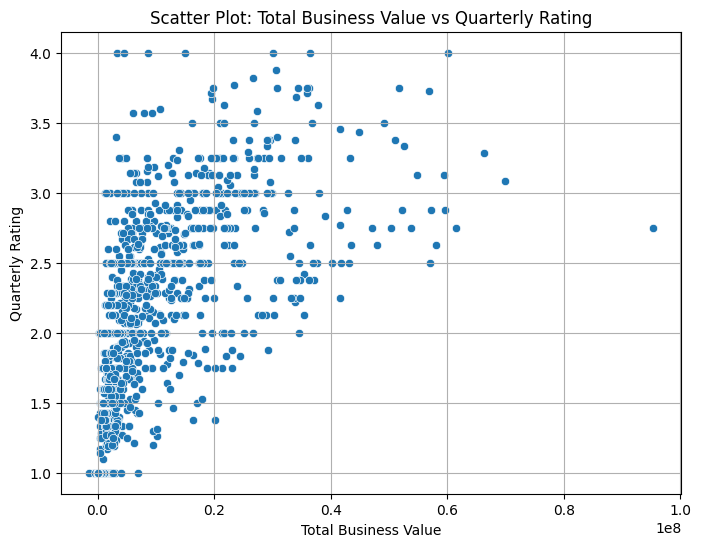

In [31]:
plot_scatterplots(df, [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Driver_ID'])

#### Analysis of Columns with Numerical-Numerical Relationships
1. Age vs. Income
   - **Observations**:
     - The scatter plot indicates no clear linear relationship between age and income.
     - Most data points are clustered around the middle-age range (30-40 years) and income levels of 40,000-80,000.
     - Some outliers are visible in the higher income range (>100,000), spread across various ages.
   - **Insights**:
     - Age does not appear to be a strong predictor of income.
     - High-income earners are present across all age groups but are concentrated in mid-age drivers.
2. Age vs. Total Business Value
   - **Observations**:
     - The majority of drivers (regardless of age) have low total business values, concentrated near zero.
     - A few outliers with high business values (above 0.6e8) are visible, primarily in mid-age groups (30-40 years).
   - **Insights**:
     - Total business value is not strongly correlated with age.
     - Drivers in mid-age groups seem to dominate higher business values, potentially due to experience or better performance.
3. Age vs. Quarterly Rating
   - **Observations**:
     - Quarterly ratings are clustered around 1.0 to 2.5 for all age groups.
     - No clear trend is visible between age and quarterly ratings.
     - Outliers with ratings >3.5 are distributed across different age groups.
   - **Insights**:
     - Age is not a strong determinant of quarterly rating.
     - Most drivers across all age groups have low to average ratings, indicating potential room for improvement in performance across the board.
4. Income vs. Total Business Value
   - **Observations**:
     - Income and total business value show a weak positive correlation.
     - Drivers with higher incomes tend to have higher business values, but the relationship is not linear.
     - Outliers with very high business values (>0.6e8) have moderate to high incomes.
   - **Insights**:
     - Drivers generating higher business values often earn higher incomes.
     - Factors beyond total business value (e.g., bonuses or performance metrics) might contribute to income variability.
5. Income vs. Quarterly Rating
   - **Observations**:
     - No strong relationship between income and quarterly ratings is visible.
     - Most data points cluster around ratings of 1.0 to 2.5, regardless of income.
     - High-income drivers (>100,000) are scattered across various rating levels.
   - **Insights**:
     - Higher income does not necessarily correlate with better quarterly ratings.
     - Ratings appear to be independent of income, possibly influenced by qualitative factors like customer feedback or punctuality.
6. Total Business Value vs. Quarterly Rating
   - **Observations**:
     - A weak positive correlation exists between total business value and quarterly ratings.
     - Drivers with higher ratings (above 3.0) generally have higher business values.
     - However, most data points are clustered at lower ratings (1.0 to 2.0) and low business values.
   - **Insights**:
     - Total business value might be a factor influencing quarterly ratings, but the relationship is not strong.
     - Improving business value could help improve quarterly ratings, but additional factors need to be considered.
General Recommendations:
- **For Income**:
  - Investigate factors influencing high incomes among certain drivers and replicate success strategies across the fleet.
  - Offer targeted incentives for drivers in the mid-income range to boost performance.
- **For Business Value**:
  - Analyze drivers with high total business values to identify and scale best practices.
  - Address cancellations/refunds that might be contributing to low business values for many drivers.
- **For Quarterly Ratings**:
  - Provide performance improvement programs for drivers with low ratings.
  - Focus on understanding the drivers of high ratings and aligning them with incentives.
- **For Age Groups**:
  - Mid-age drivers (30-40 years) tend to perform better in terms of income and business value. Leverage their experience for mentorship programs.

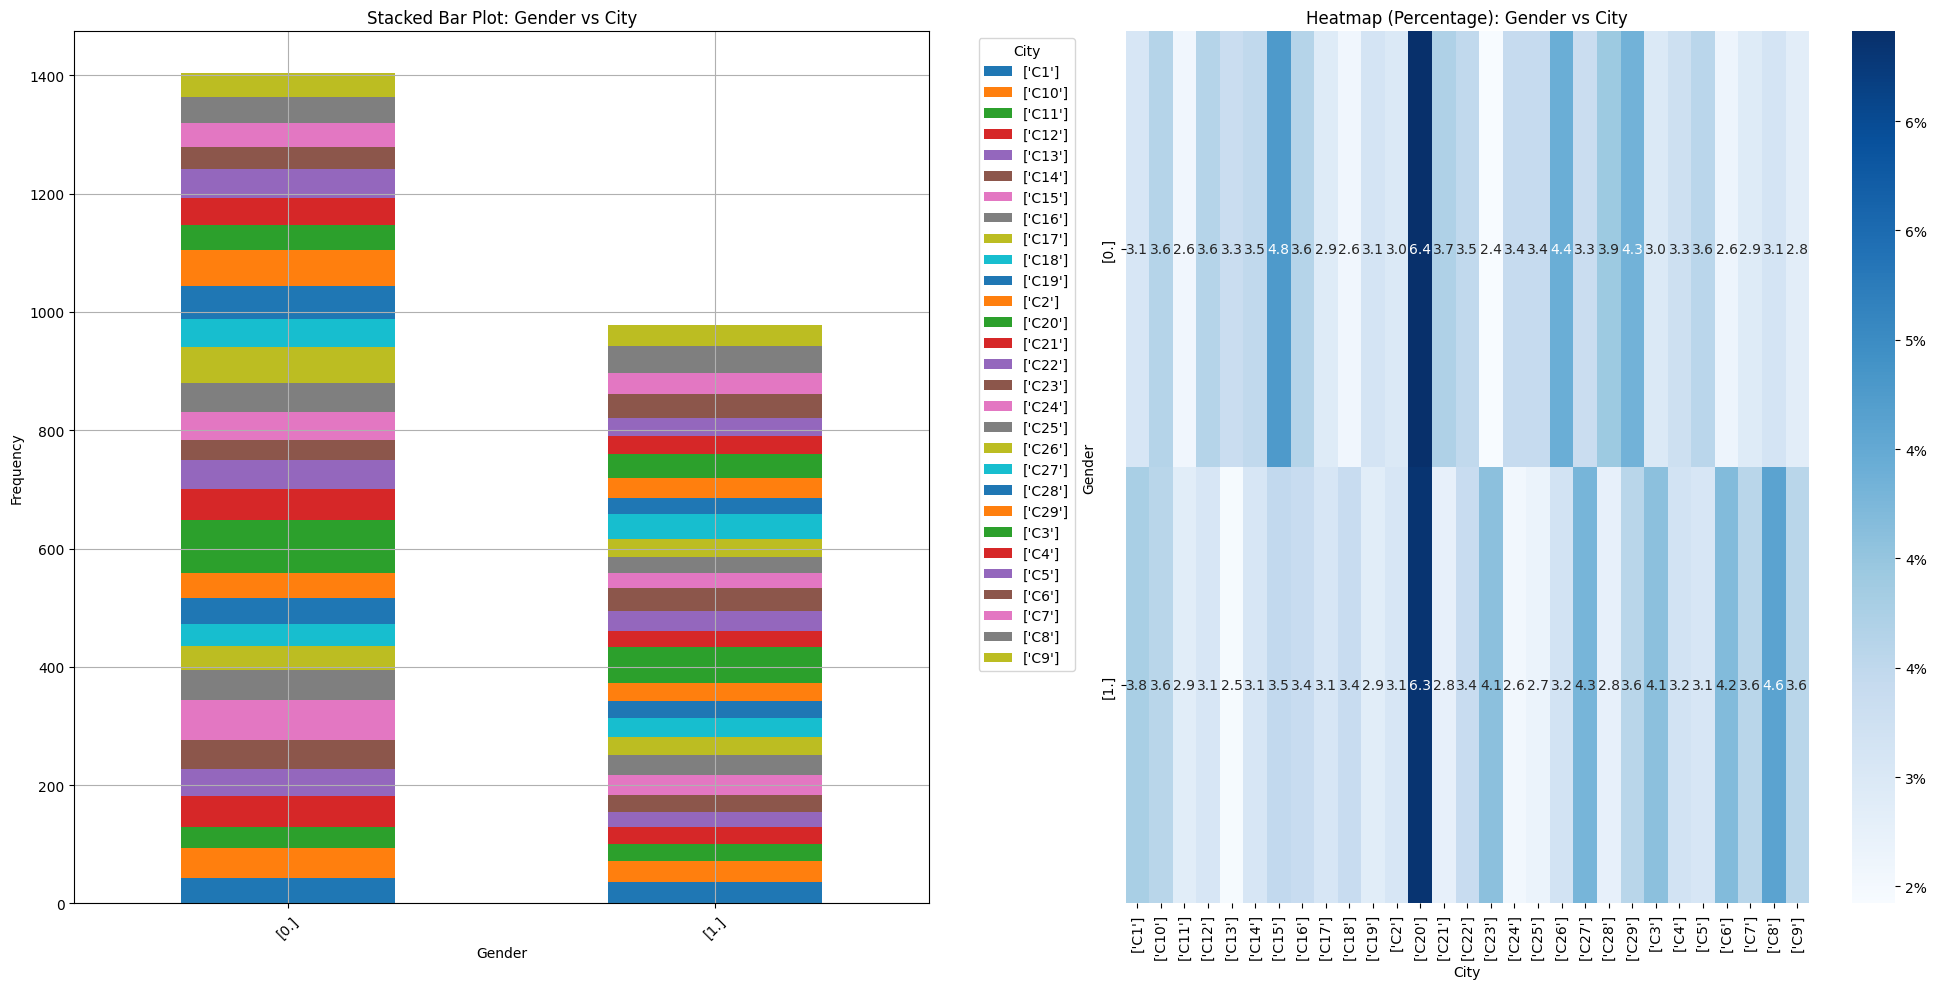

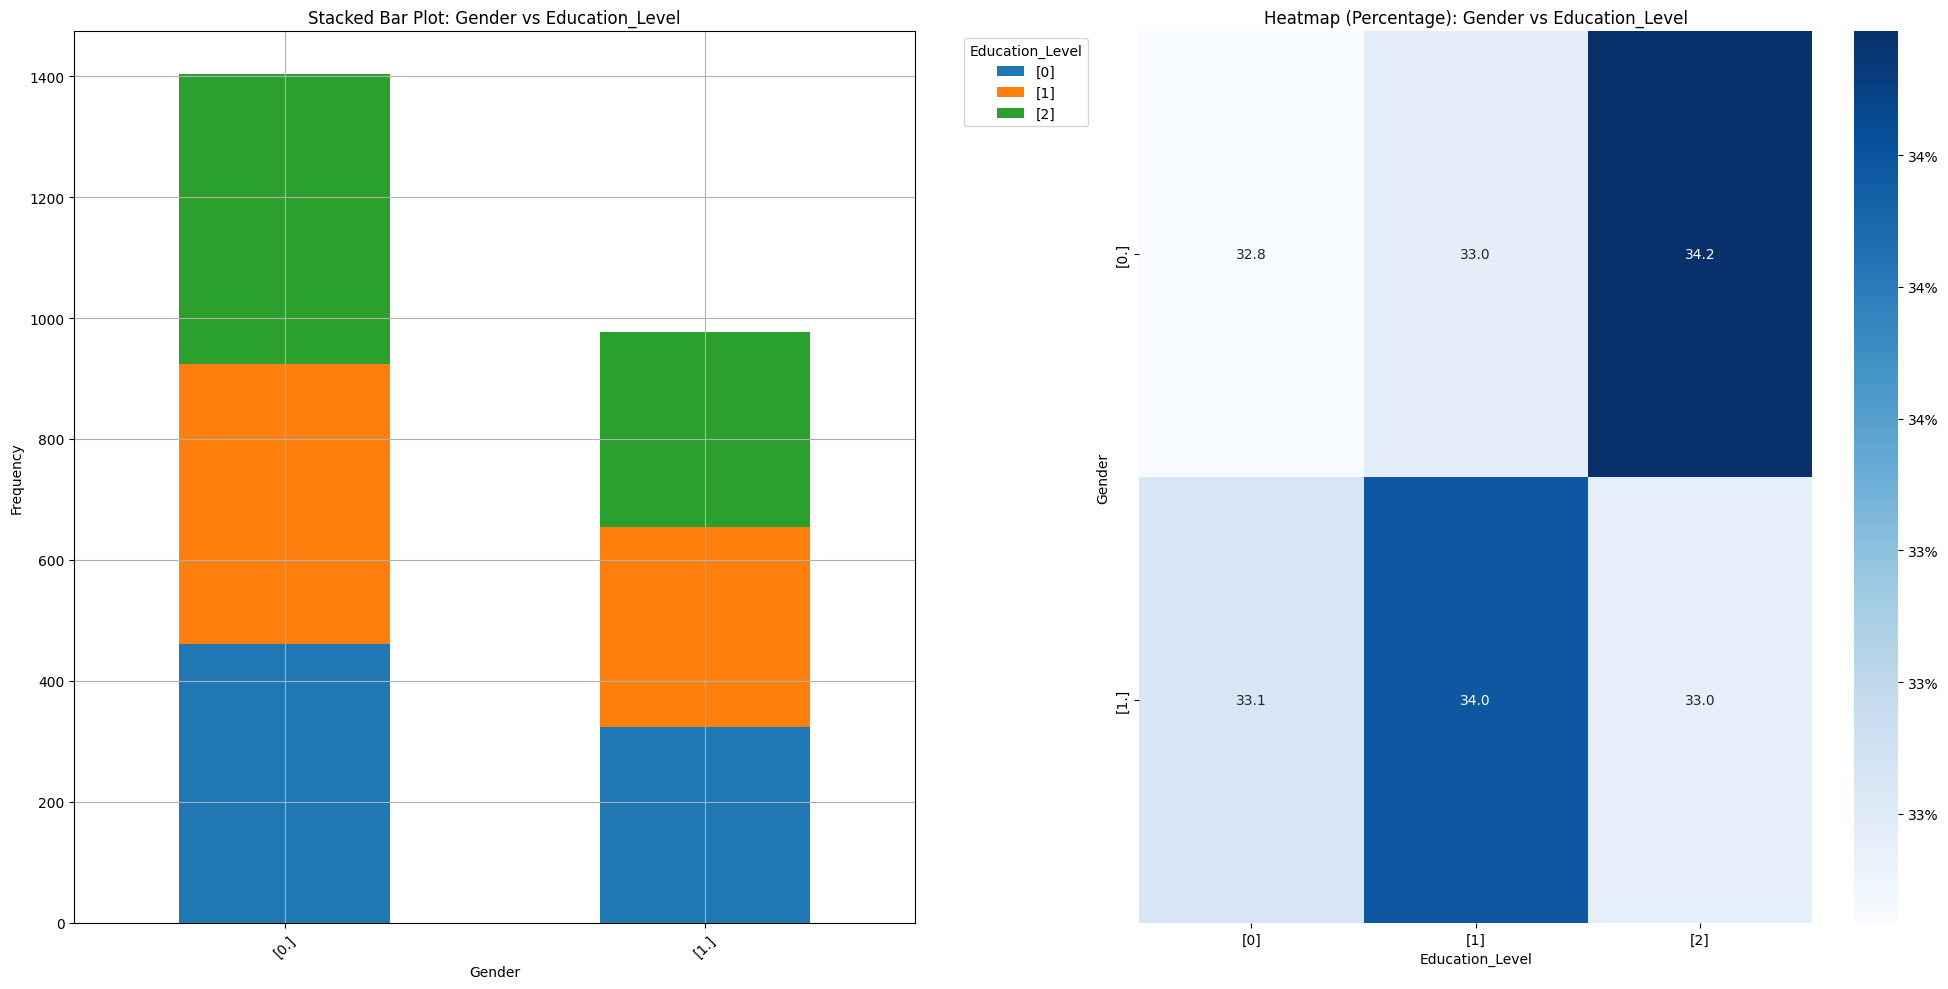

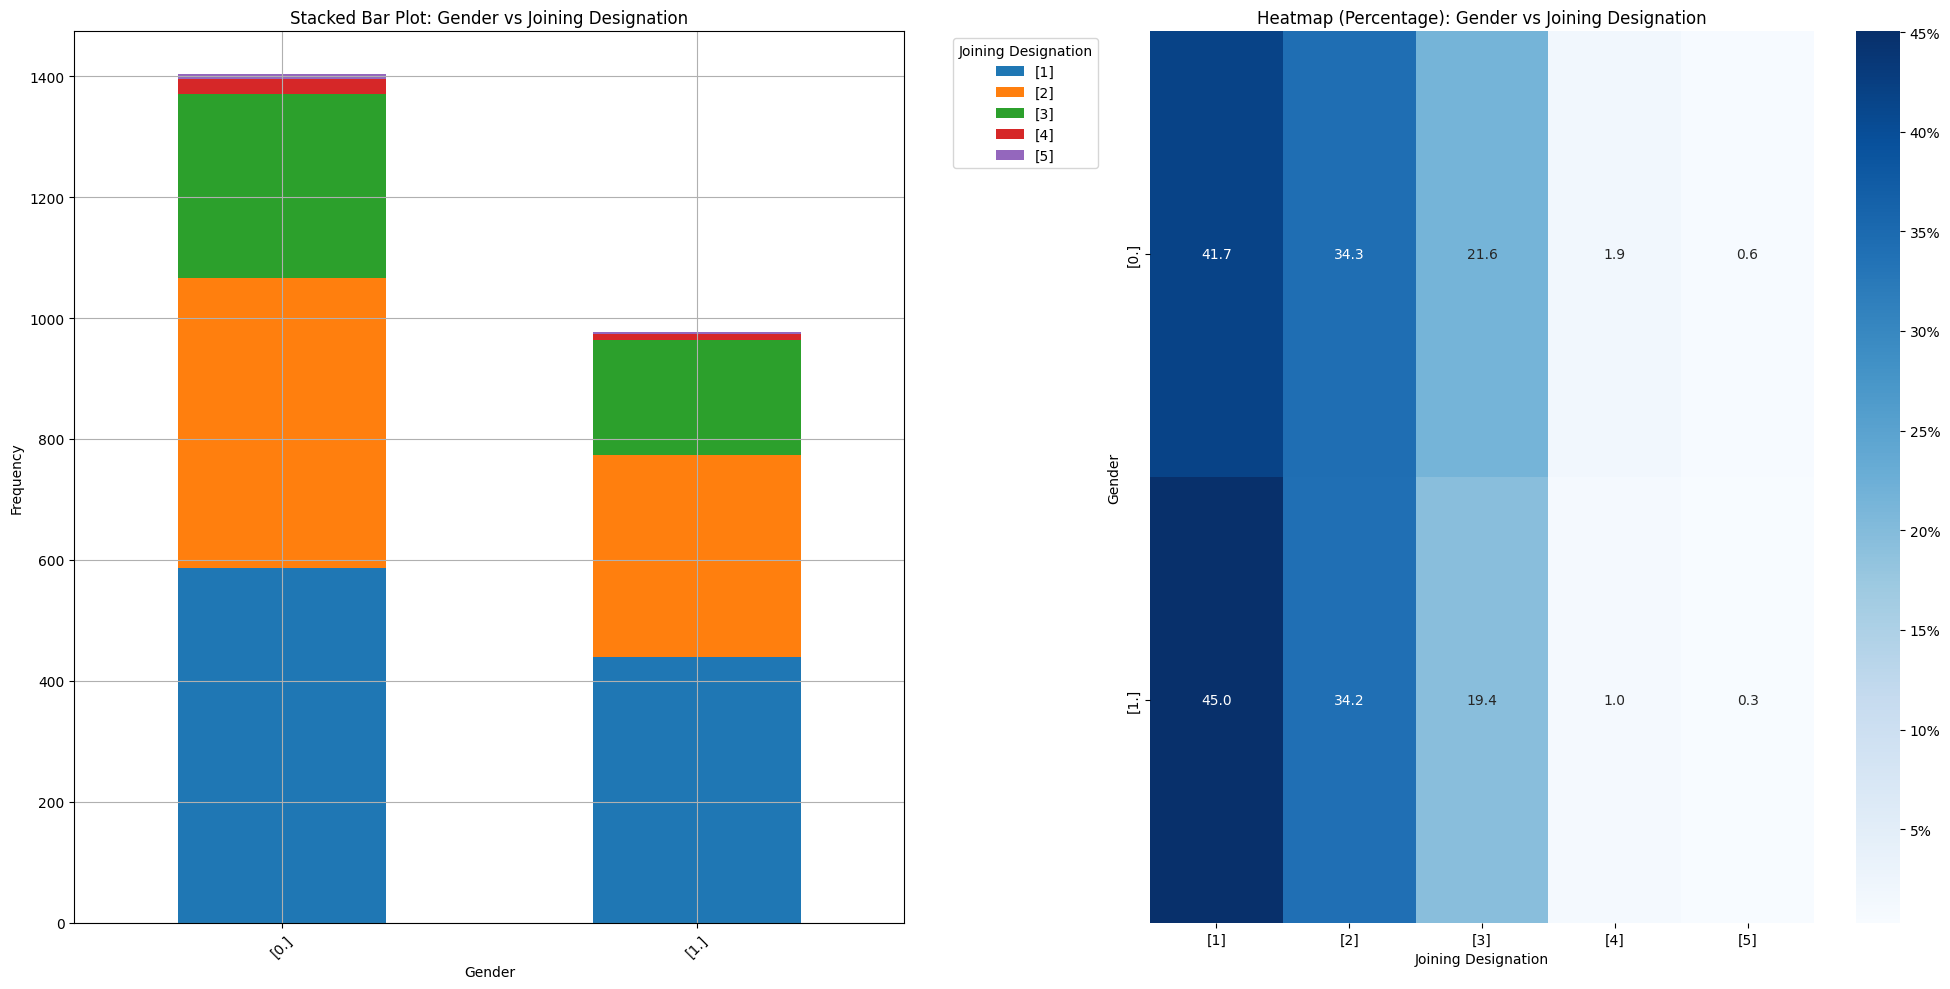

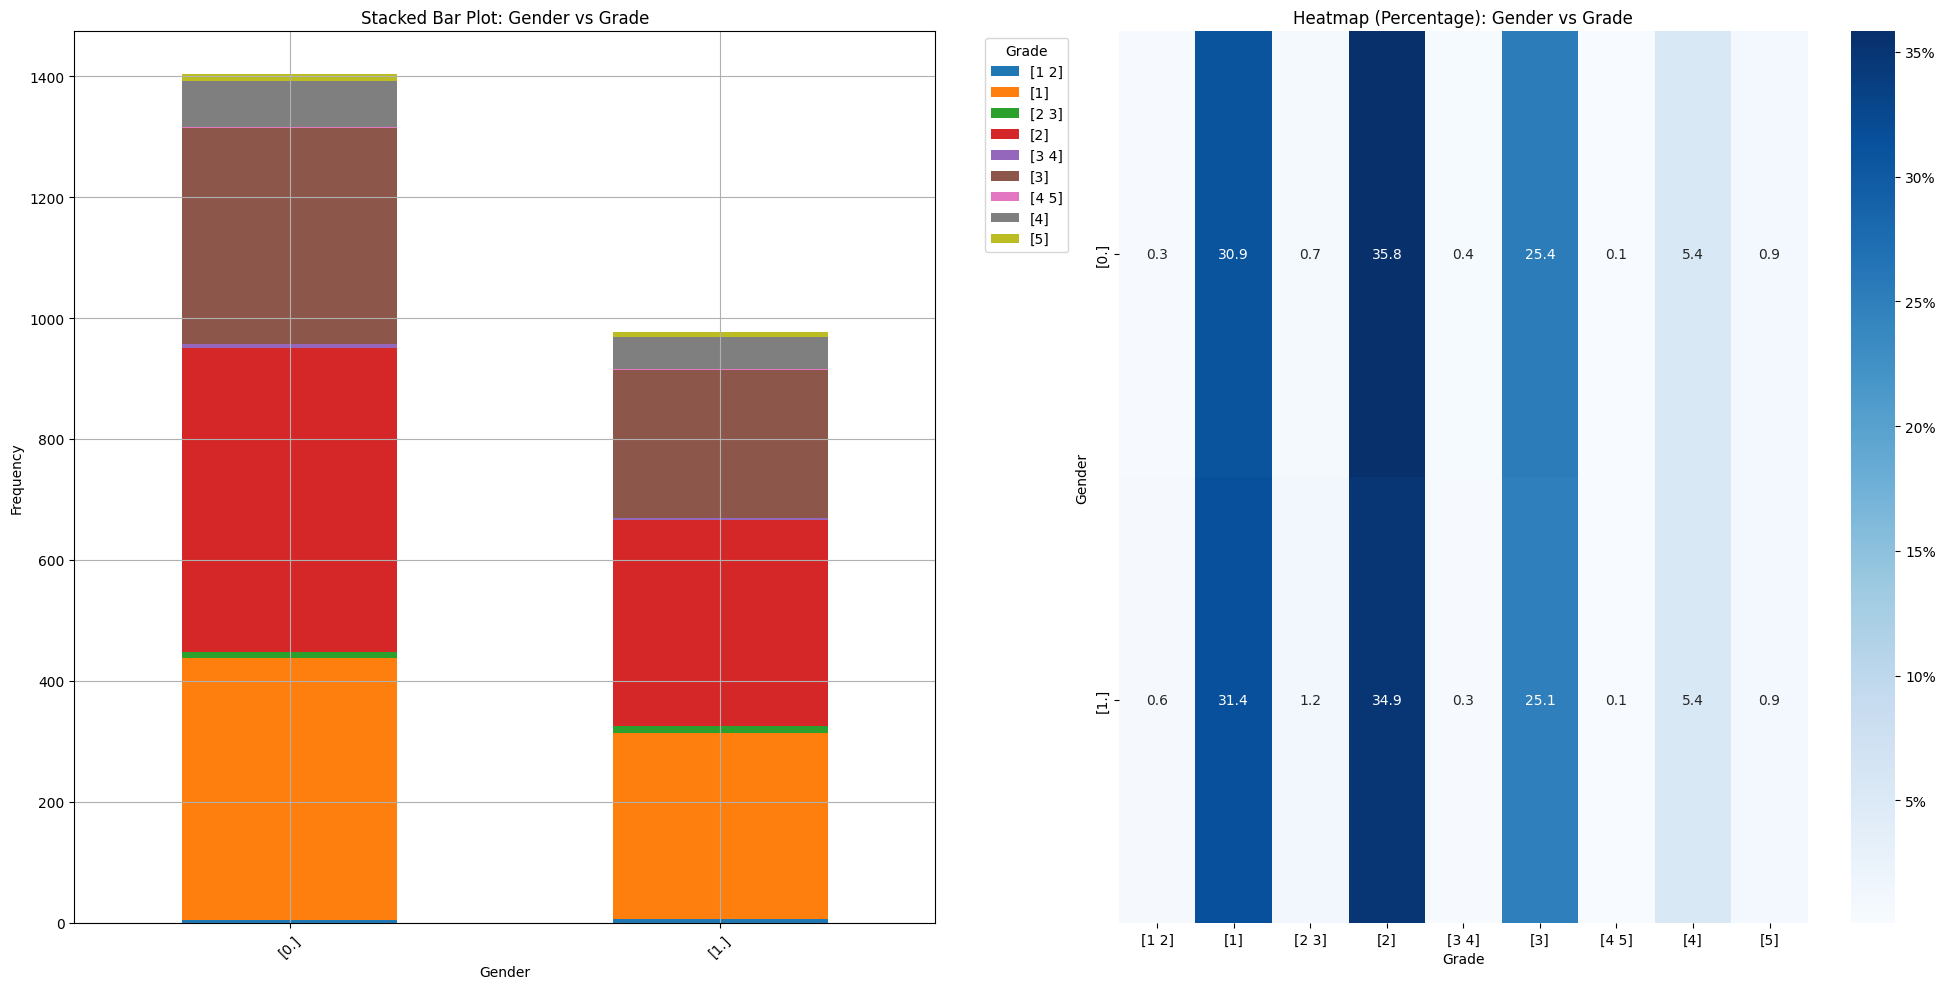

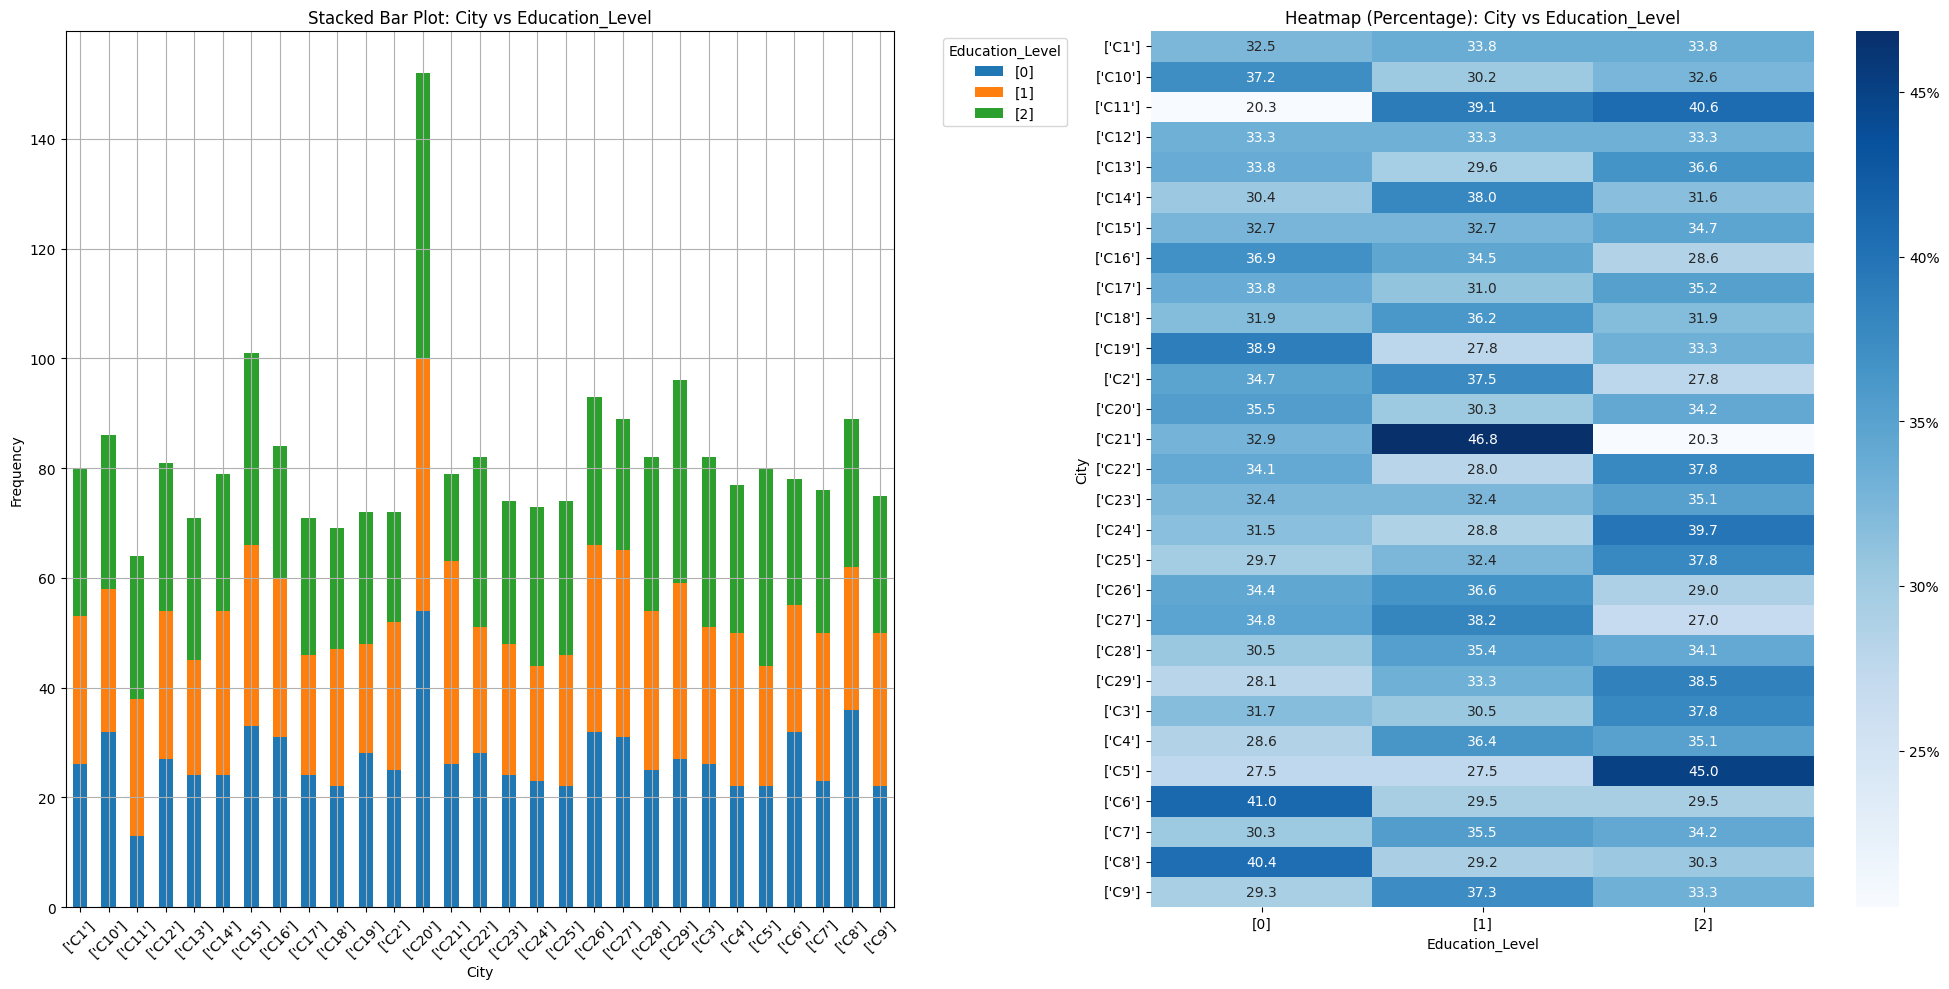

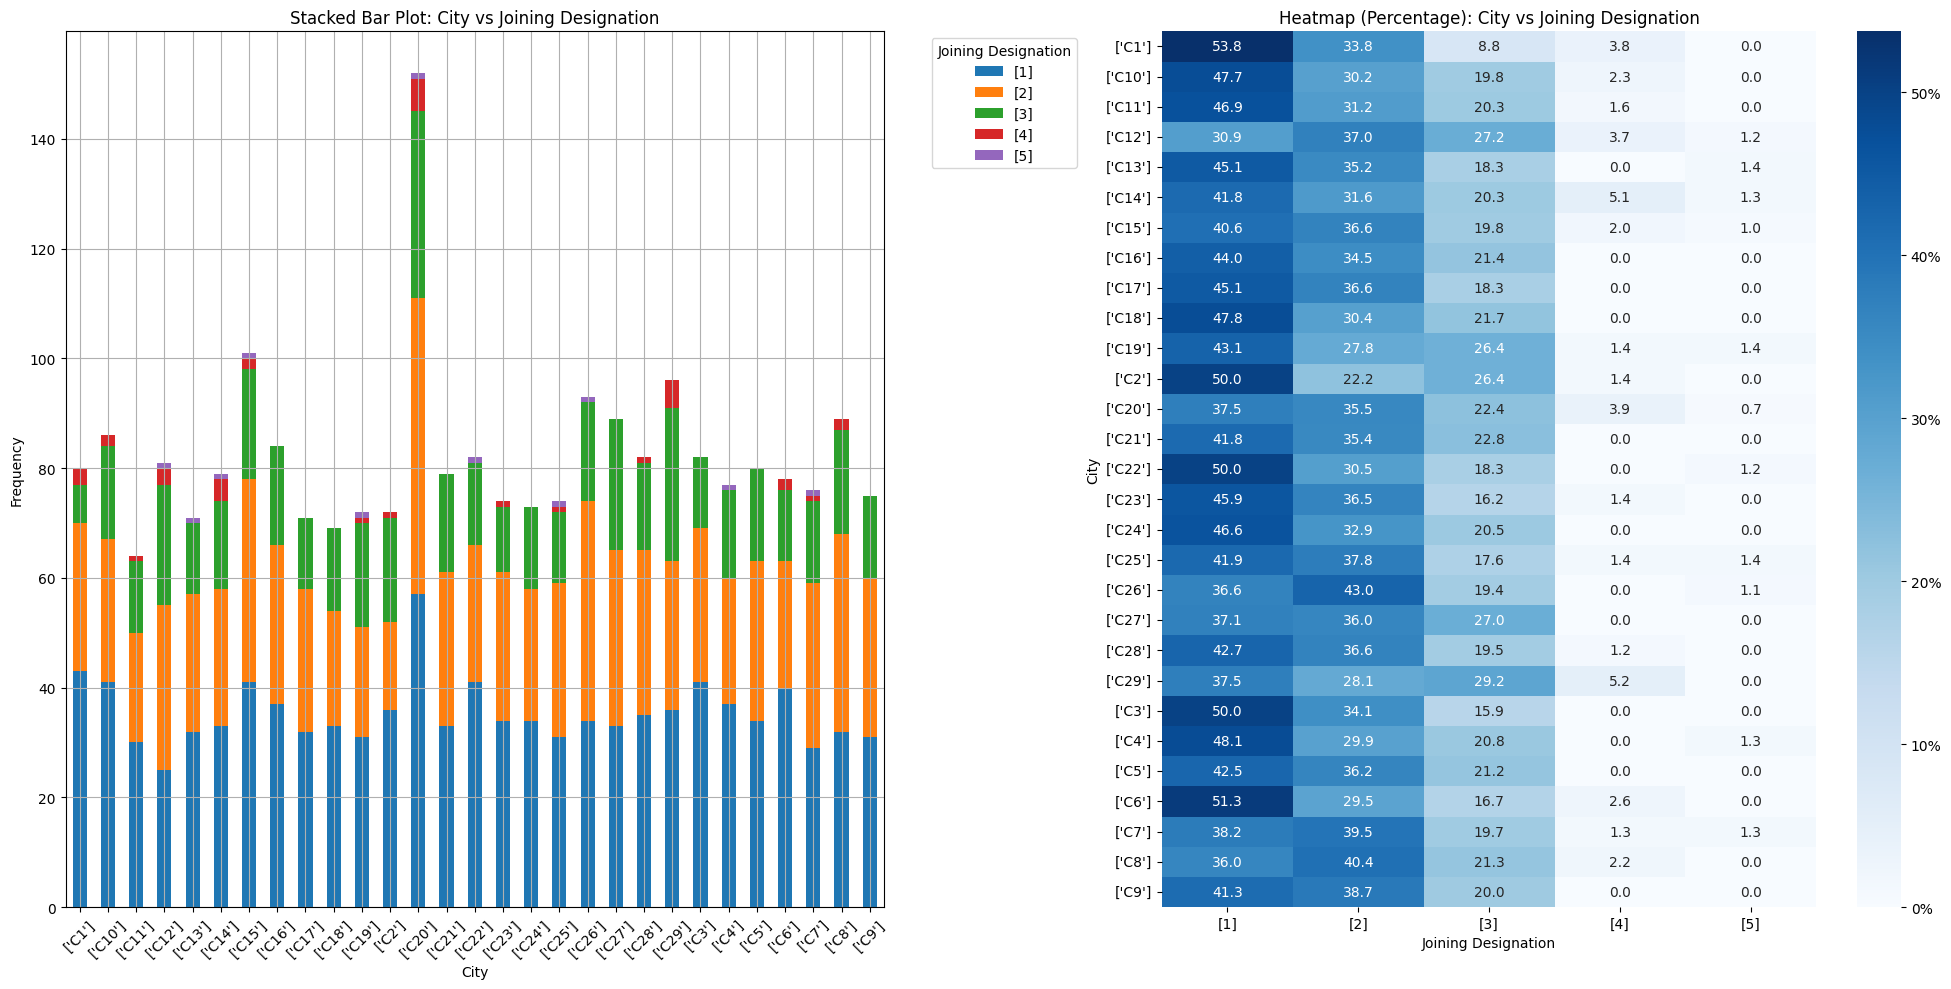

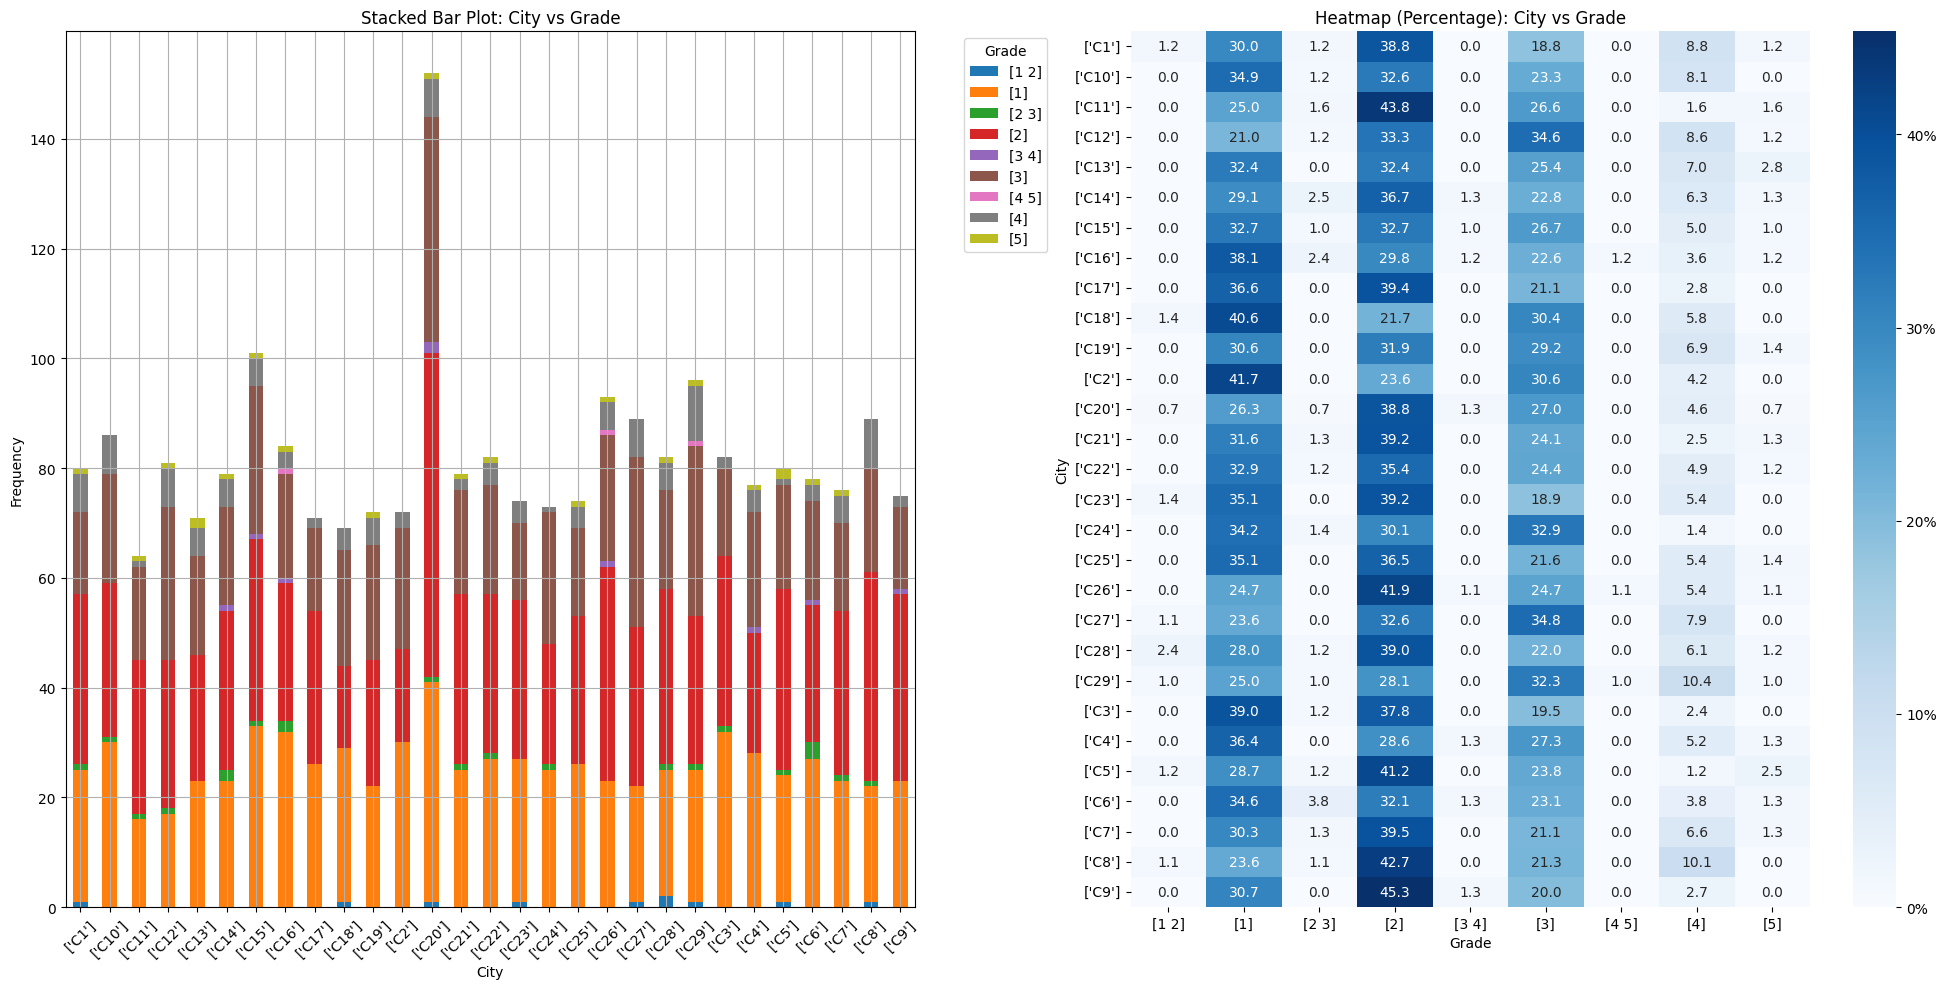

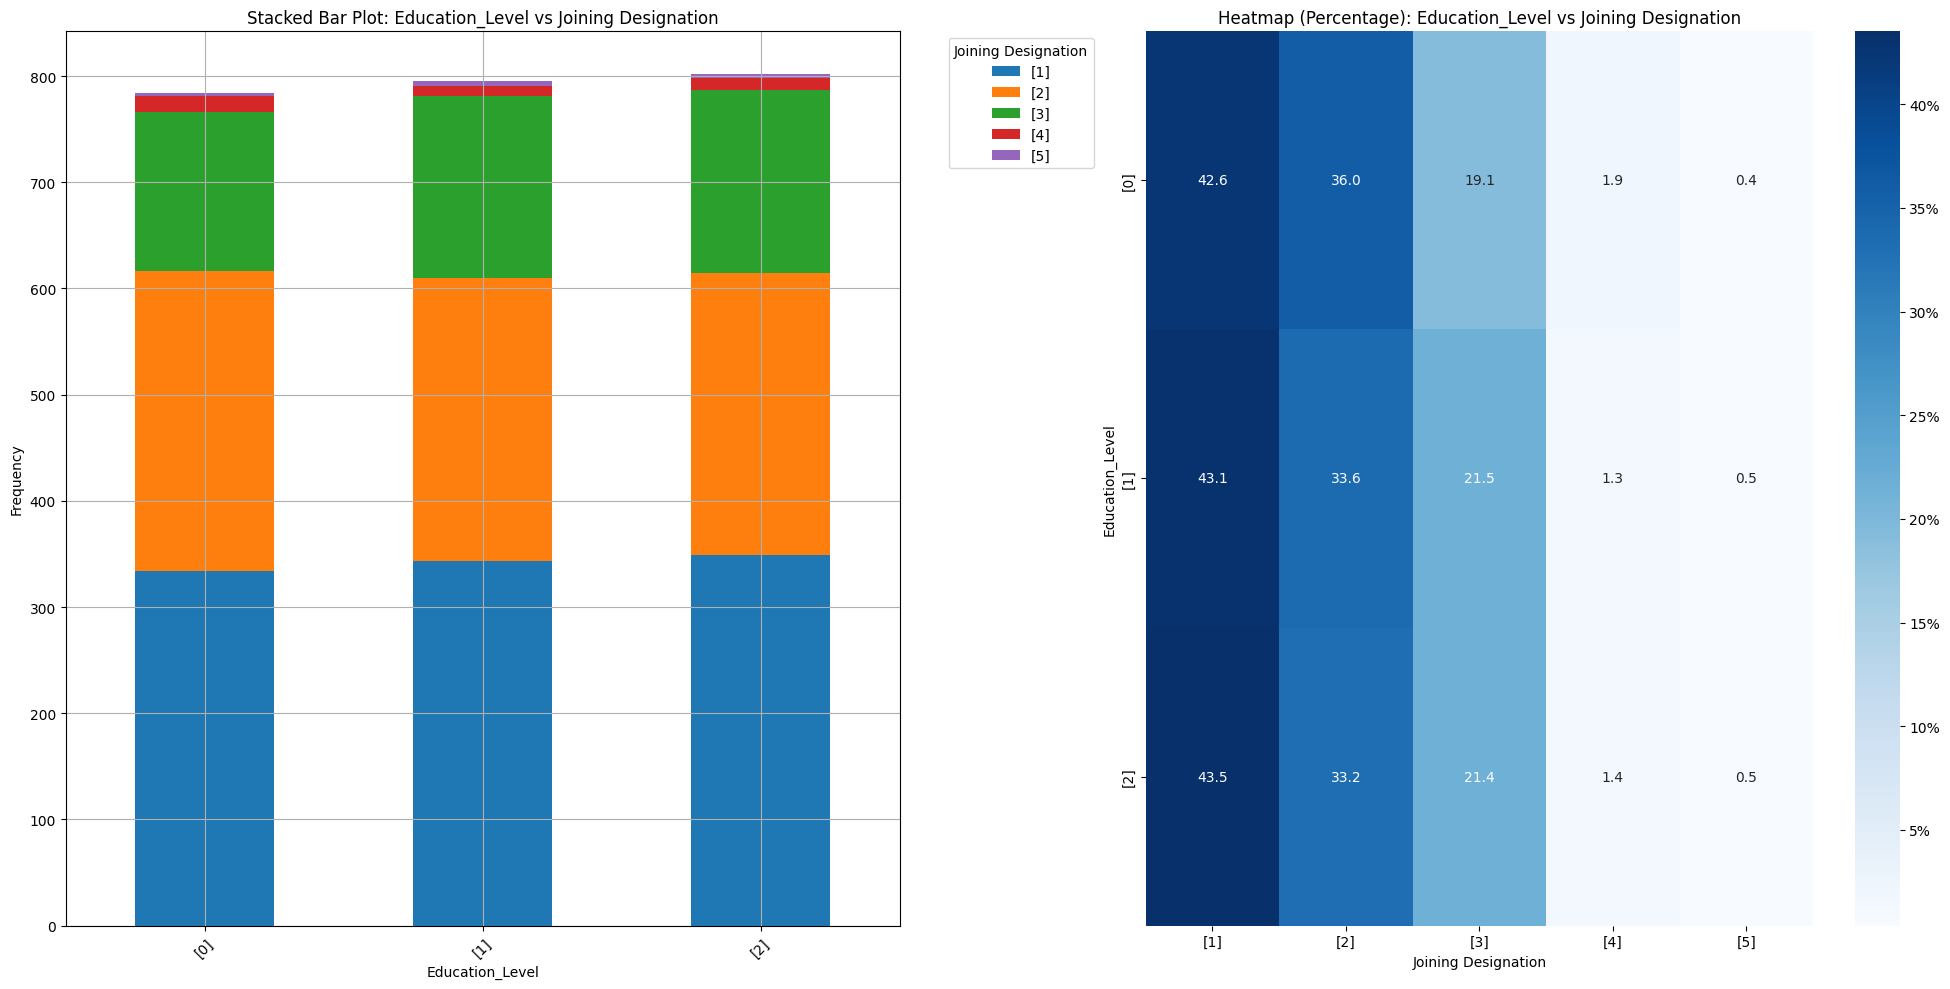

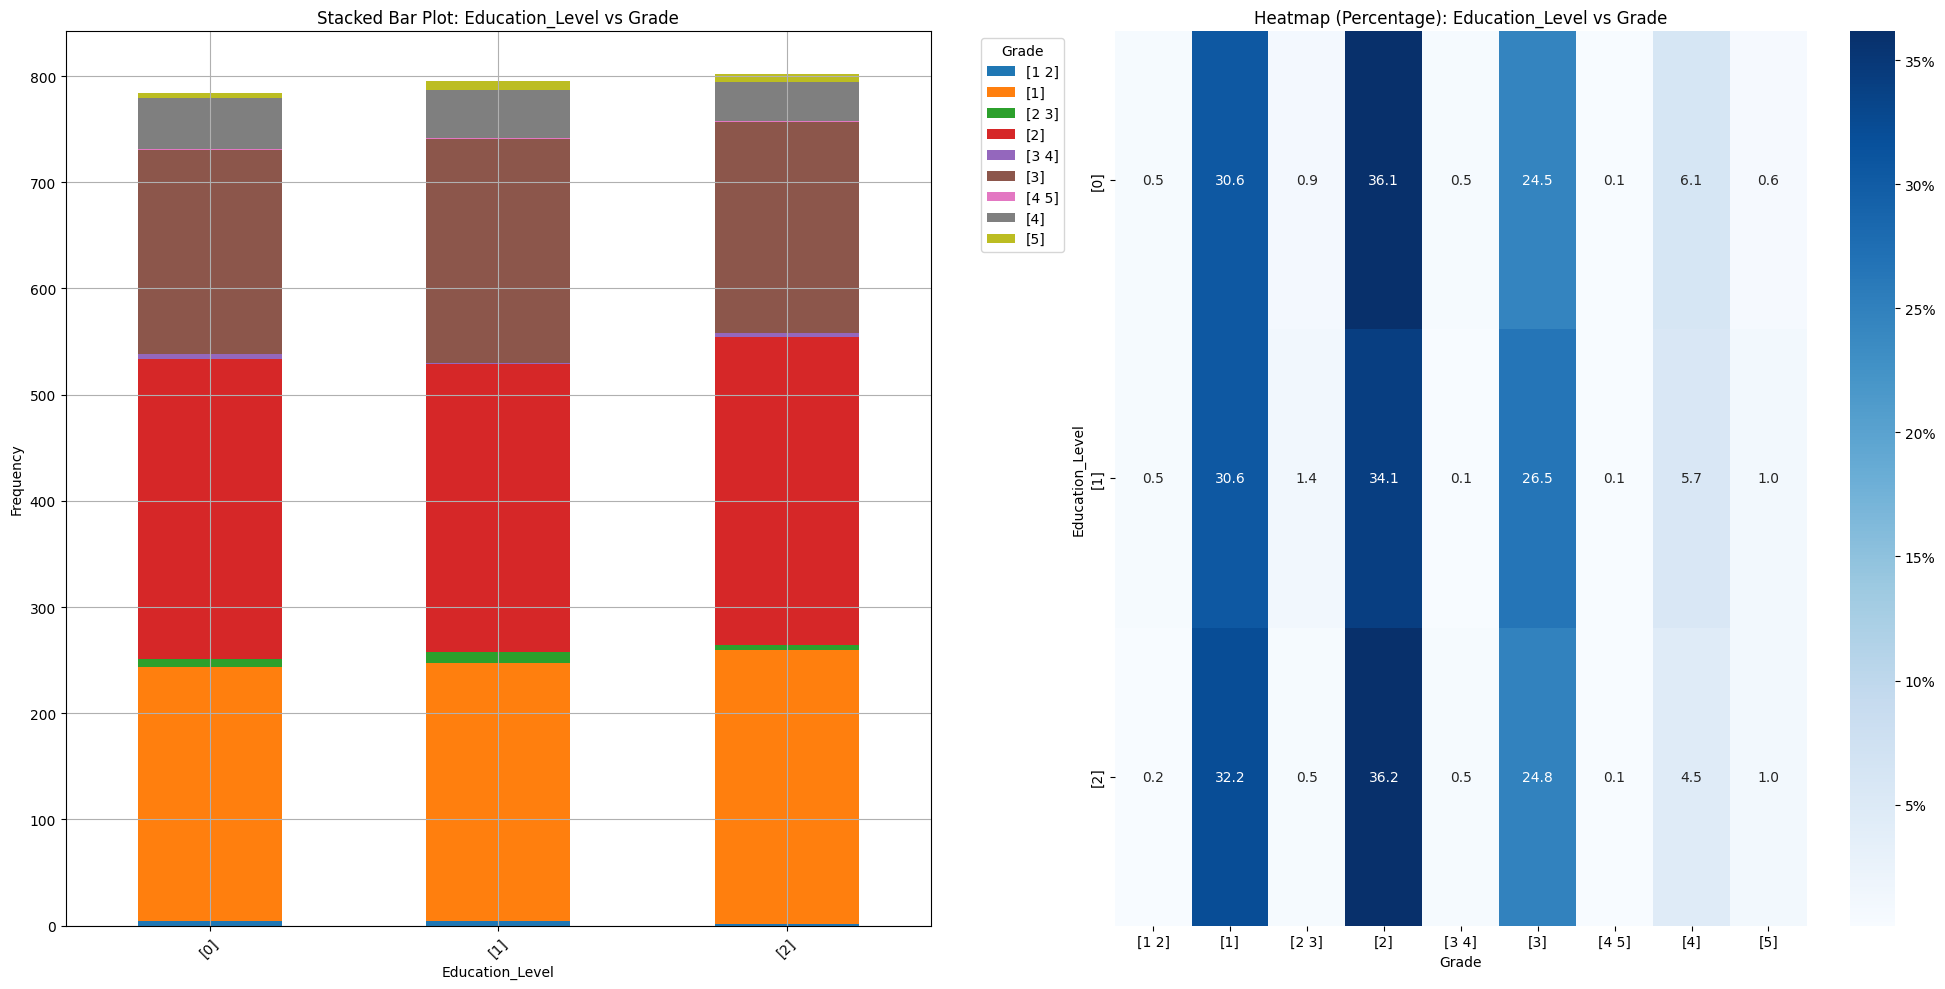

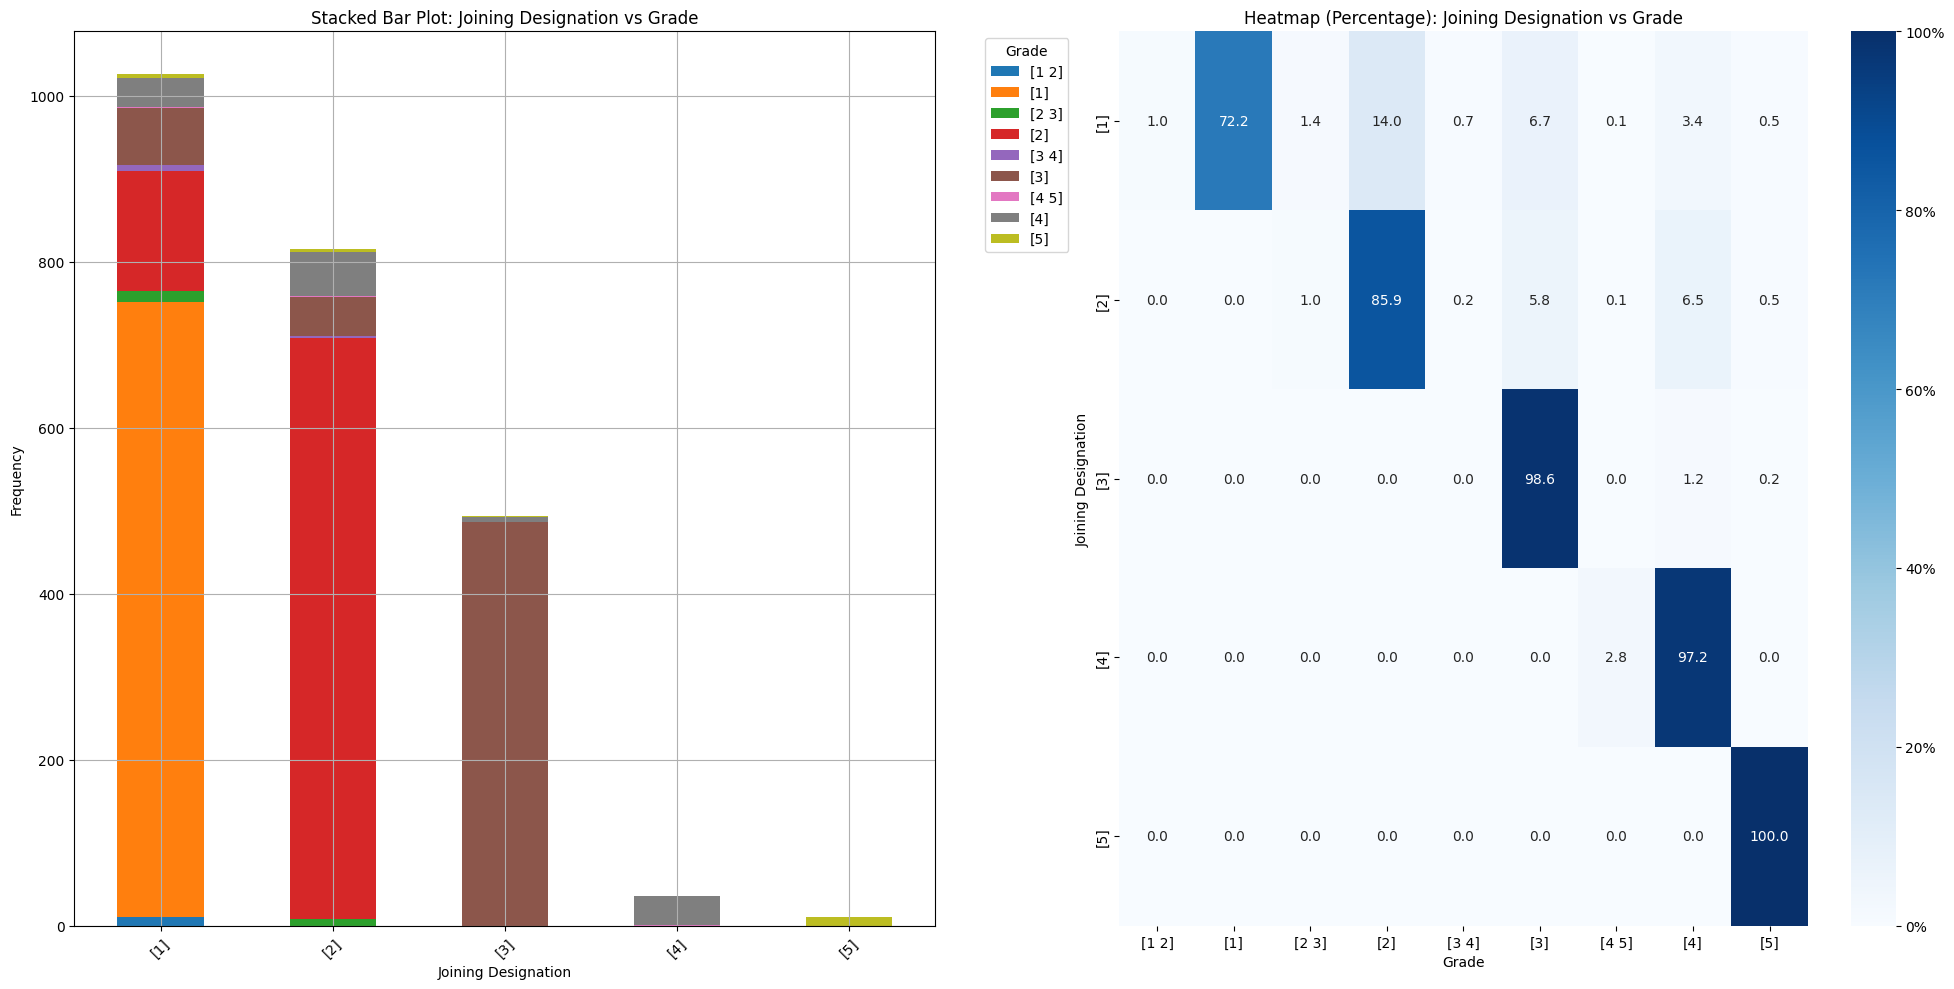

In [32]:
plot_stacked_bars_and_heatmaps(df, df.select_dtypes(include=['object', 'category']).columns.tolist())

## Analysis of Columns with Categorical-Categorical Relationship:
**Gender vs City**

- Stacked Bar Plot:
  - The distribution of genders across cities is relatively balanced.
  - City `C20` has the highest representation for both genders.
  - Certain cities display slight gender preferences, indicating possible regional trends.

- Heatmap (Percentage):
  - Cities like `C20` show higher percentages of one gender.
  - Some cities, such as `C6` and `C8`, have near-equal gender distributions, highlighting balanced participation.

**Gender vs Education Level**

- Stacked Bar Plot:
  - Education levels are evenly distributed between genders.
  - A significant portion of drivers are graduates, equally represented across genders.

- Heatmap (Percentage):
  - Graduates (`2`) dominate among both genders.
  - Minimal variation between genders suggests a balanced distribution of educational qualifications.

**Gender vs Joining Designation**

- Stacked Bar Plot:
  - Designation `1` is the most common across both genders.
  - Senior roles (`4`, `5`) have minimal representation for both genders.

- Heatmap (Percentage):
  - Males (`0`) dominate entry-level positions (`1`), while senior roles show limited participation across genders.

**Gender vs Grade**

- Stacked Bar Plot:
  - Grades `2` and `3` are most common for both genders, indicating consistent performance distributions.
  - Higher grades (`4` and `5`) have sparse representation.

- Heatmap (Percentage):
  - Grade `2` exhibits a balanced gender distribution.
  - Marginal gender differences are observed in higher grades.

**City vs Education Level**

- Stacked Bar Plot:
  - City `C20` has the highest number of graduates, followed by other education levels.
  - Smaller cities demonstrate a more balanced distribution of education levels.

- Heatmap (Percentage):
  - Graduates dominate in cities like `C21` and `C6`.
  - Certain cities show a higher percentage of lower education levels.

**City vs Joining Designation**

- Stacked Bar Plot:
  - City `C20` leads in Designation `1`, while other cities distribute fairly across entry and mid-level roles.
  - Senior roles (`4`, `5`) show limited representation across cities.

- Heatmap (Percentage):
  - Cities `C1` and `C3` display a high percentage of entry-level positions, with minimal representation in senior roles.

**City vs Grade**

- Stacked Bar Plot:
  - Cities like `C20` dominate in Grade `2`.
  - Higher grades have limited representation across cities.

- Heatmap (Percentage):
  - Balanced participation in Grades `1` and `2` is observed across cities.
  - Higher grades show negligible differences among cities.

**Education Level vs Joining Designation**

- Stacked Bar Plot:
  - Designation `1` is the most common across all education levels.
  - Senior roles show minimal distribution.

- Heatmap (Percentage):
  - Entry-level positions dominate across all education levels.
  - Higher designations reveal limited differences between education levels.

**Education Level vs Grade**

- Stacked Bar Plot:
  - Grades `2` and `3` are prevalent across all education levels.
  - Higher grades have sparse distribution.

- Heatmap (Percentage):
  - Graduates and lower education levels are equally distributed in Grades `1` and `2`.
  - Higher grades show minimal representation differences.

**Joining Designation vs Grade**

- Stacked Bar Plot:
  - Entry-level grades are most prominent in Designations `1` and `2`.
  - Higher grades show minimal representation across all designations.

- Heatmap (Percentage):
  - Grades `2` and `3` dominate entry-level positions.
  - Senior grades are rarely represented in higher designations.


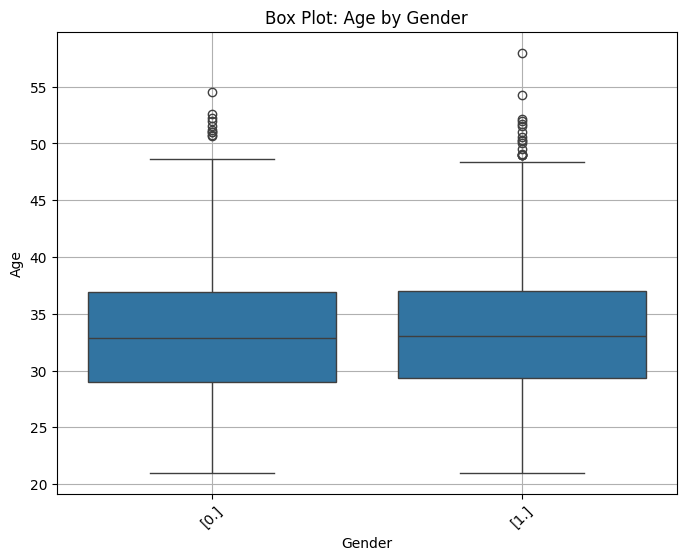

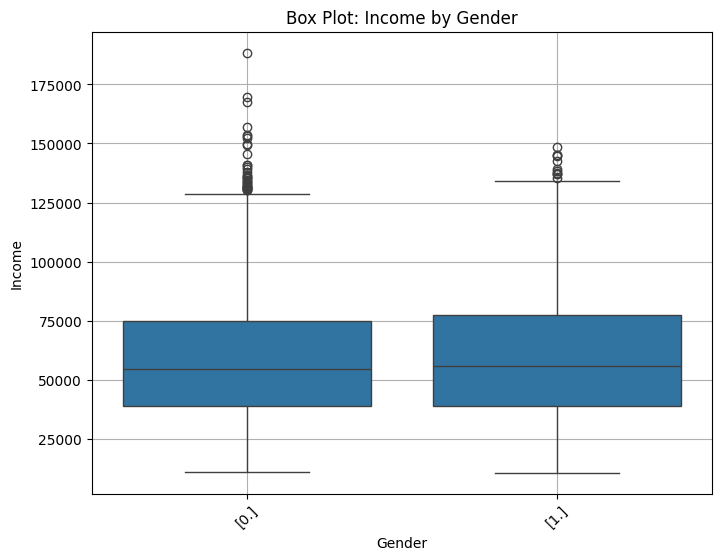

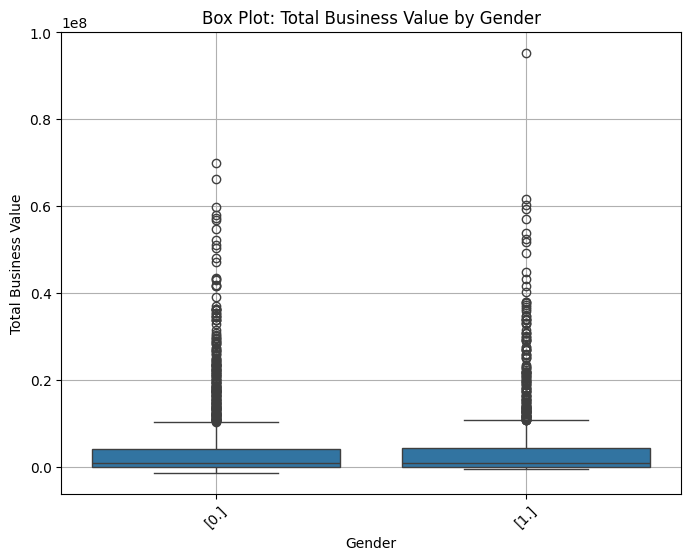

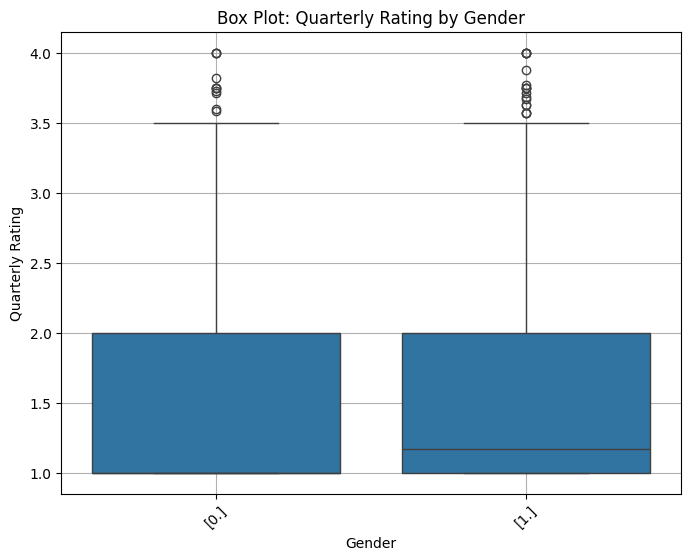

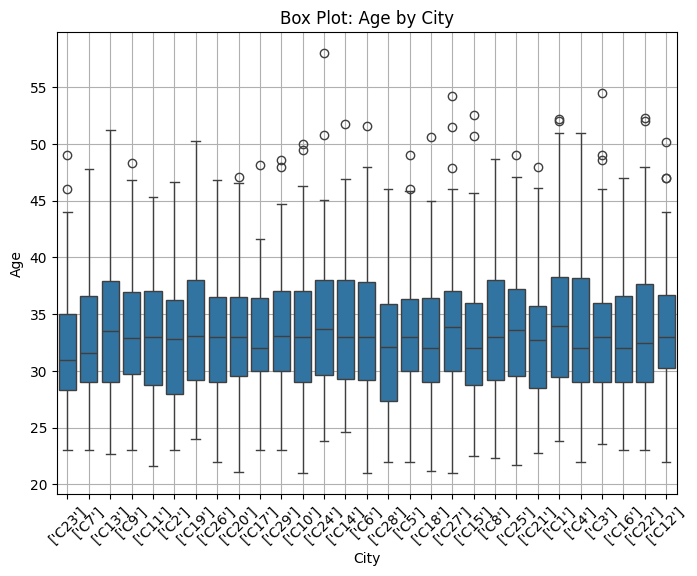

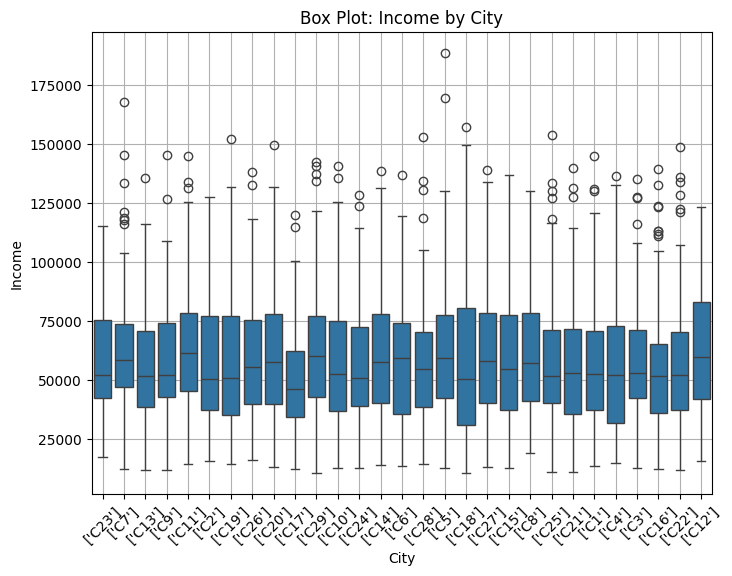

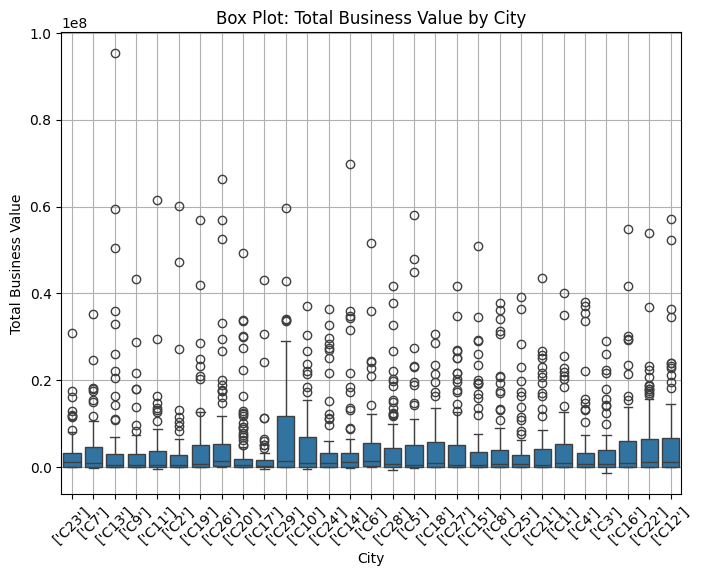

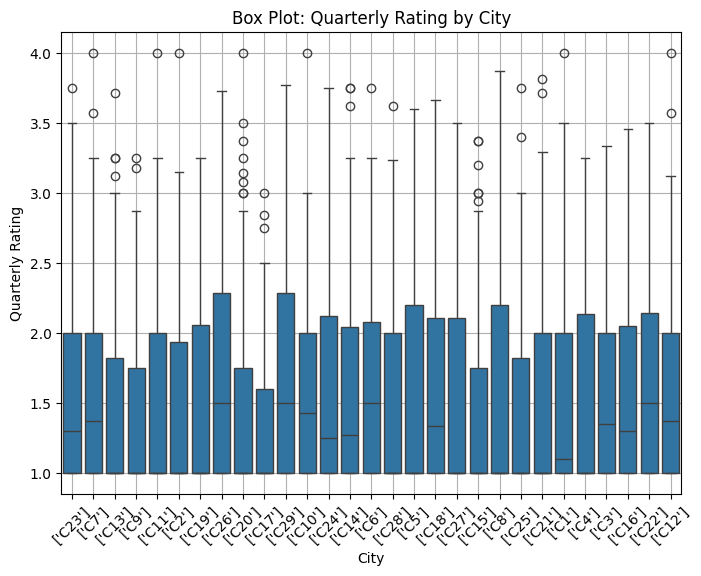

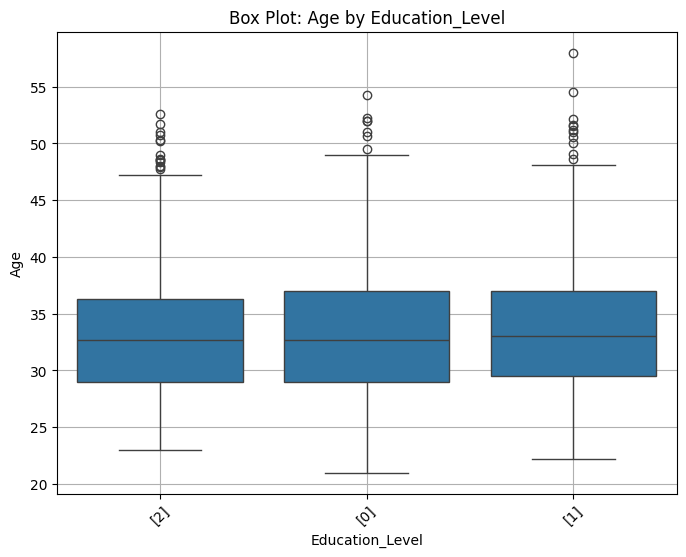

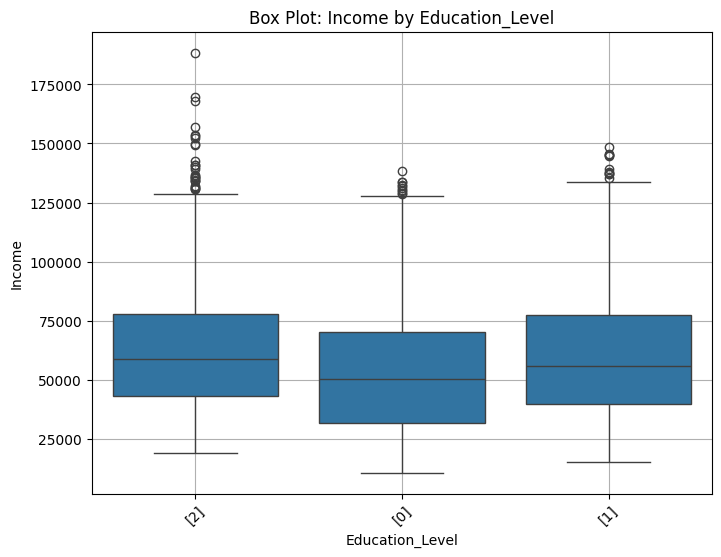

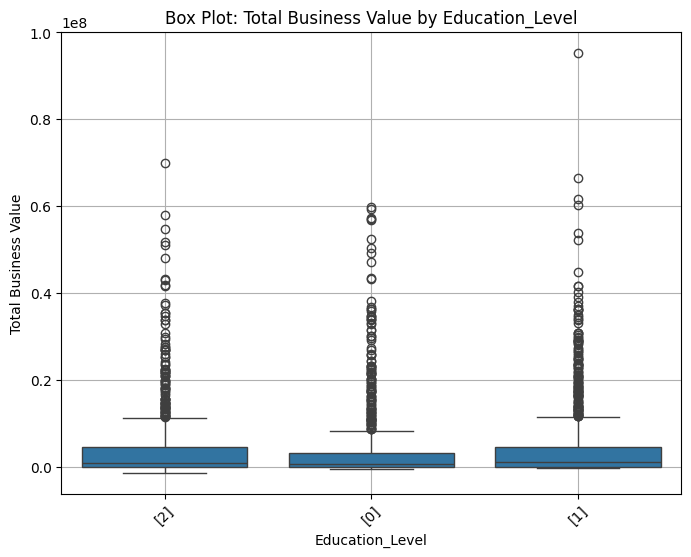

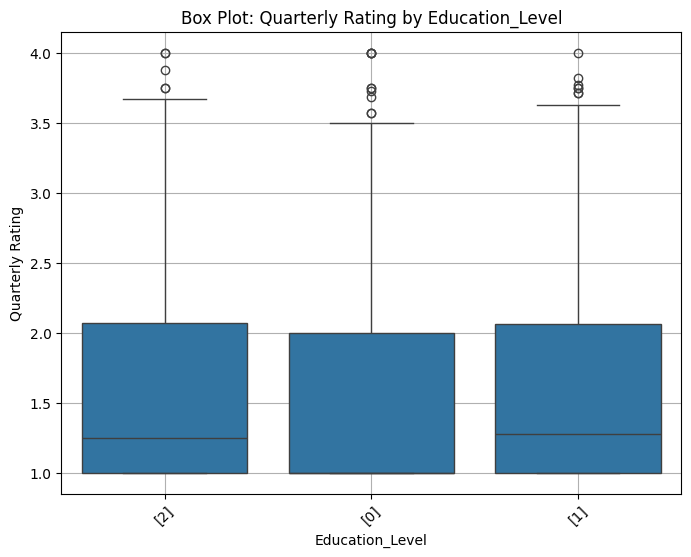

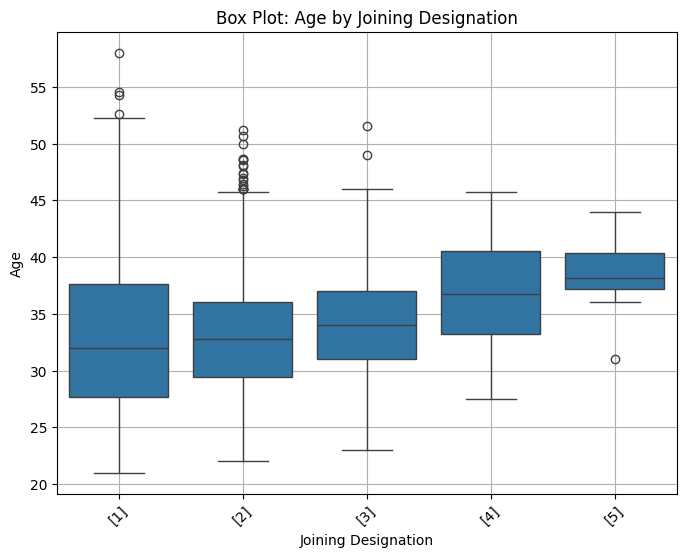

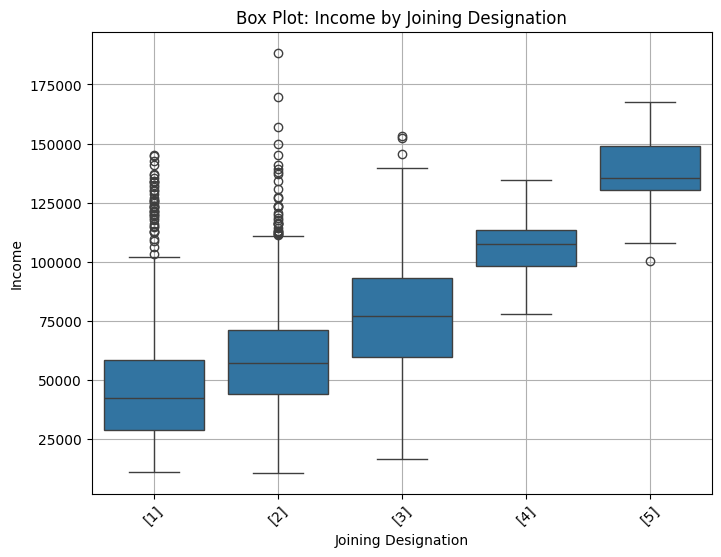

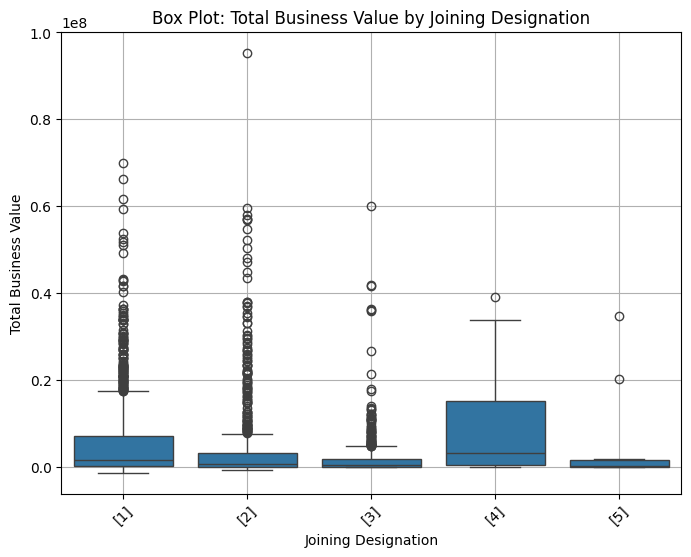

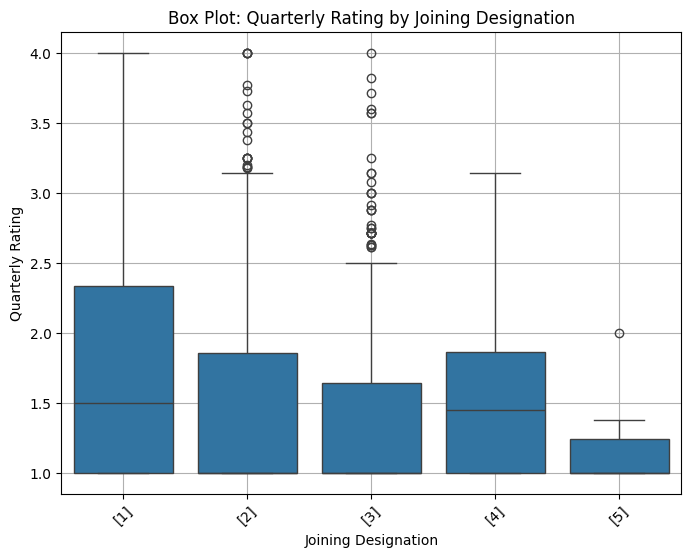

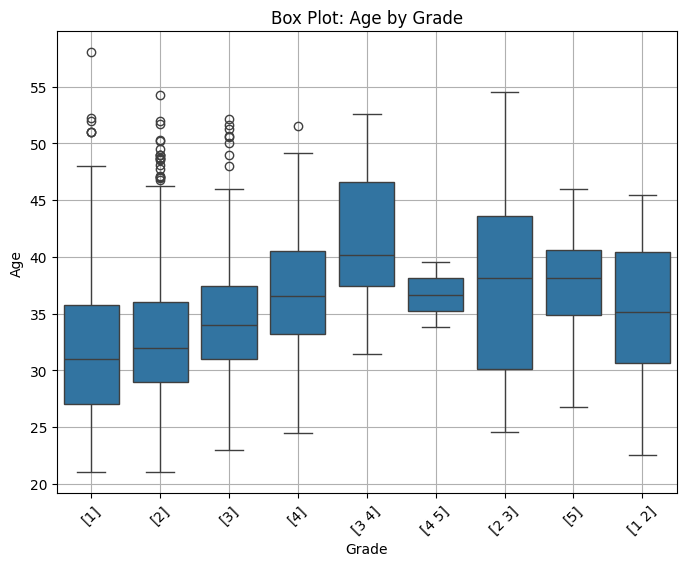

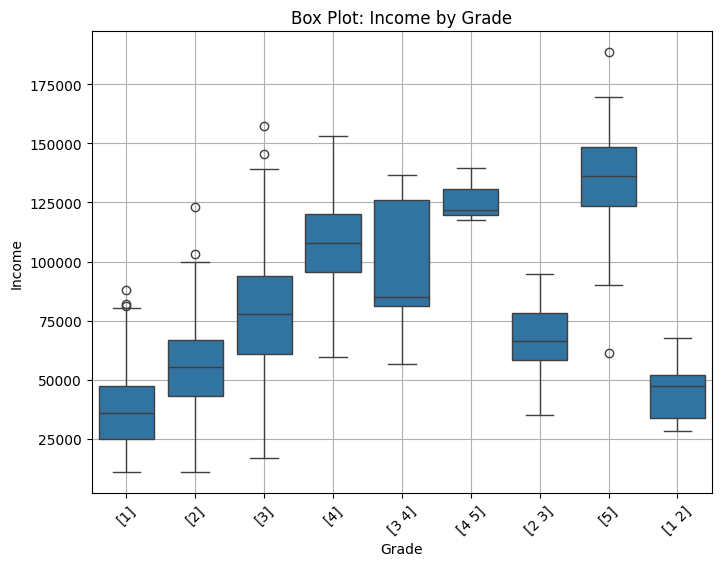

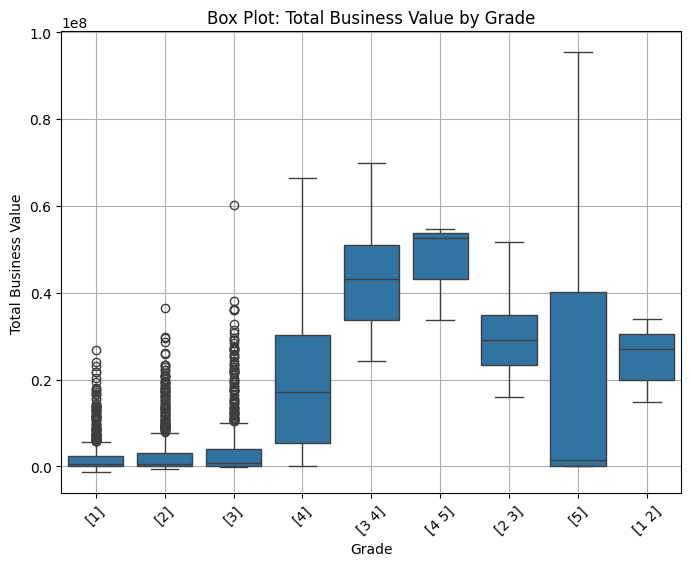

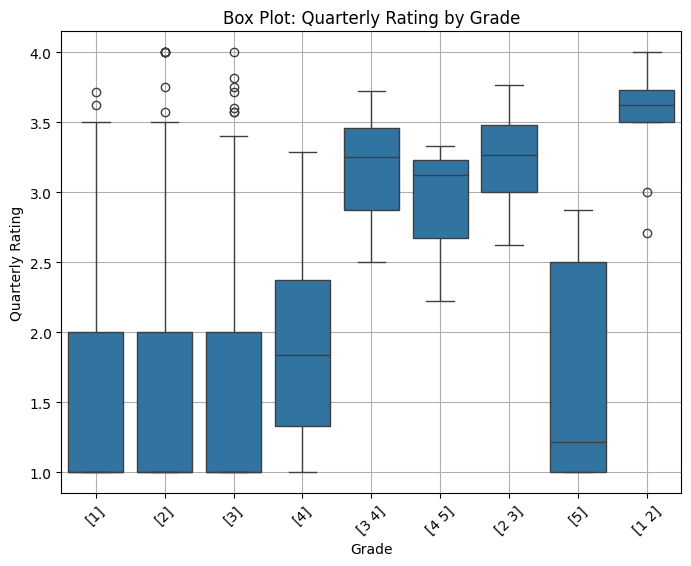

In [44]:
for cat_col in ['Gender', 'City', 'Education_Level', 'Joining Designation', 'Grade']:
    df[cat_col] = df[cat_col].astype(str)
plot_boxplots(df, df.select_dtypes(include=['object', 'category']).columns.tolist(), [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Driver_ID'])

## Analysis of Columns with Categorical-Numerical Relationship:
- **Age by Gender:**  
  Both genders show a similar distribution of ages. The median age is consistent across genders, and a few outliers with higher ages are observed for both groups.

- **Income by Gender:**  
  The distribution of income is similar for both genders, with a slightly higher number of outliers at higher income levels for one gender. Median income remains consistent, indicating no significant gender-based disparity.

- **Total Business Value by Gender:**  
  The distribution of total business value is narrow for most data points, but both genders exhibit numerous outliers. Median values show minimal variation.

- **Quarterly Rating by Gender:**  
  Ratings are consistent between genders, although one group has a slightly wider distribution. A few outliers are present at higher ratings.

- **Age by City:**  
  Most cities have a similar age range and median values. Certain cities exhibit more outliers, reflecting a broader age distribution.

- **Income by City:**  
  Income distribution across cities is comparable. However, some cities have slightly higher income medians, suggesting location-based earning variations.

- **Education Level Analysis:**  
  - **Age:** Median ages across education levels are similar, with slightly older individuals in higher education levels.  
  - **Income:** Higher education correlates with slightly higher income, although medians remain close.  
  - **Total Business Value:** Minimal differences are observed across education levels, but significant outliers exist.  
  - **Quarterly Rating:** Ratings are consistent across education levels, with minimal variations.

- **Joining Designation:**  
  - **Age:** Higher designations are associated with older employees, indicated by a median shift.  
  - **Income:** An upward trend in income is observed with higher designations.  
  - **Total Business Value:** Higher designations generally correspond to larger business values, with notable outliers.  
  - **Quarterly Rating:** Median ratings slightly decline with higher designations.

- **Grade-Based Observations:**  
  - **Age:** Predictably, age increases with grade level.  
  - **Income:** Higher grades exhibit a rise in income.  
  - **Total Business Value:** Total business value increases with grade level, accompanied by more outliers.  
  - **Quarterly Rating:** Rating distributions vary more across grades, with higher grades showing more scattered data.

In [45]:
df

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.000000,[0.],['C23'],[2],57387.0,2018-12-24,2019-11-03,[1],[1],1715580,2.000000
1,2,31.000000,[0.],['C7'],[2],67016.0,2020-06-11,NaT,[2],[2],0,1.000000
2,4,43.000000,[0.],['C13'],[2],65603.0,2019-07-12,2020-04-27,[2],[2],350000,1.000000
3,5,29.000000,[0.],['C9'],[0],46368.0,2019-09-01,2019-07-03,[1],[1],120360,1.000000
4,6,31.000000,[1.],['C11'],[1],78728.0,2020-07-31,NaT,[3],[3],1265000,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,33.500000,[0.],['C24'],[0],82815.0,2015-10-15,NaT,[2],[3],21748820,2.625000
2377,2785,34.000000,[1.],['C9'],[0],12105.0,2020-08-28,2020-10-28,[1],[1],0,1.000000
2378,2786,44.888889,[0.],['C19'],[0],35370.0,2018-07-31,2019-09-22,[2],[2],2815090,1.666667
2379,2787,28.000000,[1.],['C20'],[2],69498.0,2018-07-21,2019-06-20,[1],[1],977830,1.500000
